In [1]:
from keras.utils import to_categorical
from keras.optimizers import Adam, Adadelta, SGD
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPool2D, Dropout, Flatten, Conv1D, GlobalAveragePooling1D, Convolution1D
from keras.layers.convolutional import MaxPooling2D, MaxPooling1D
from keras.models import load_model
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.utils import class_weight
from scipy import signal
from glob import glob
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

c:\users\sebastiaan\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# constants:
SUBSAMPLE = 10  # scales the data by this factor
COLUMNS = ['HandStart', 'FirstDigitTouch',
        'BothStartLoadPhase', 'LiftOff',
        'Replace', 'BothReleased']
TRAIN_SUBJECTS = range(9, 13)
TEST_SUBJECTS = range(9, 13)
N_LABELS = 6

# Below are the paths to the data. Please pay attention to the % and * signs, these are needed in the loop.
TRAIN_DATA_PATH = 'C:/Users/Sebastiaan/Desktop/Programming/MachineLearning/Datasets/EEG/train/subj%d_series*_data.csv'
# TRAIN_DATA_PATH = 'C:/Users/bas/Documents/MachineLearning/train/subj%d_series*_data.csv'

EPOCHS = 100
WINDOW_SIZE = 200
SPLIT_SIZE = 50
BATCH_SIZE = 10

In [3]:
def prepare_training_data(data_path):
    data = pd.read_csv(data_path)
    event_path = data_path.replace('_data', '_events')
    labels = pd.read_csv(event_path)
    clean_data = data.drop(['id'], axis = 1)
    labels = labels.drop(['id'], axis = 1)
    return clean_data, labels

In [4]:
def preprocess_data(x_raw, WINDOW_SIZE, subsample):
    x_raw, scaler = scaler_transform(x_raw[::subsample], None)
    x_raw = image_mappping(x_raw, WINDOW_SIZE)
    return x_raw, scaler

In [5]:
def scaler_transform(data, scaler):
    if scaler == None:
        scaler = Normalizer()
        return scaler.fit_transform(data), scaler
    else:
        return scaler.transform(data)   

In [6]:
def read_training_data(train_data_paths):
    labels_raw = []
    features_raw = []
    for data_path in train_data_paths:
        data, labels = prepare_training_data(data_path)
        features_raw.append(data)
        labels_raw.append(labels)
    features_raw = pd.concat(features_raw)
    labels_raw = pd.concat(labels_raw)
    x_train = np.asarray(features_raw.astype(float))
    y_train = np.asarray(labels_raw.astype(float))
    return x_train, y_train

In [7]:
def metric_auc_score(predictions, y_test, with_plot):
    scores = []
    legend_text = []
    for i in range(N_LABELS):
        fpr, tpr, _  = roc_curve(y_test[:,i], predictions[:,i], 1)
        scores.append(roc_auc_score(y_test[:,i], predictions[:,i]))
        legend_text.append(COLUMNS[i]+' (area = %.3f)' % (scores[i]))
        if with_plot == True:
            plt.plot(fpr, tpr)
    if with_plot == True:
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves')
        plt.legend(legend_text)
        plt.show()
    return scores

In [8]:
def multiple_metric_auc_score(prediction_total, test_data_total, with_plot):
    legend_text = []
    counter = 0
    for i in range(len(prediction_total)):
        fpr, tpr, _  = roc_curve(test_data_total[i], prediction_total[i], pos_label=1)
        score = roc_auc_score(test_data_total[i],prediction_total[i])
        legend_text.append(COLUMNS[i]+' (area = %.3f)' % (score))
        print(COLUMNS[i]+' AUC score = %.3f' % (score))
        plt.plot(fpr, tpr)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves')
        plt.legend(legend_text)
    plt.show()

In [9]:
def single_metric_auc_score(predictions, y_test, with_plot, i):
    fpr, tpr, _  = roc_curve(y_test, predictions, 1)
    score = roc_auc_score(y_test, predictions)
    print(COLUMNS[i]+' AUC score = %.3f' % (score))
    if with_plot == True:
        plt.plot(fpr, tpr)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves')
        plt.show()
    return score

In [10]:
def all_auc_scores(prediction_total, test_data_total, subjects, with_plot):
    scores = []
    for subject in subjects:
        score = metric_auc_score(prediction_total[subject-1],
                                 test_data_total[subject-1], with_plot)
        scores.append(score)
        print('Mean AUC Score of Subject %d: %.3f' % \
              (subject, np.mean(score)))
    return scores

In [11]:
def image_mappping(x_train, WINDOW_SIZE):
    result = []
    empty_matrix = np.zeros(np.shape(x_train[0:WINDOW_SIZE]))
    for i in range(len(x_train)):
        if i-WINDOW_SIZE < 0:
            result.append(empty_matrix)
        else:
            result.append(x_train[i-WINDOW_SIZE:i])
    return result

In [12]:
def resample_and_shuffle(labels):
    when_task = np.where(labels == 1)
    when_no_task = np.where(labels == 0)
    when_no_task = when_no_task[0][0:len(when_task[0])]
    indices = np.concatenate([when_task[0], when_no_task])
    np.random.shuffle(indices)
    return indices

In [13]:
def balance_set(indices, x_train, y_train):
    balance_x = []
    balance_y = []
    for index in indices:
        balance_x.append(x_train[index])
        balance_y.append(y_train[index])
    return balance_x, balance_y

In [14]:
def remove_imbalance(x_train, y_train):
    indices = resample_and_shuffle(y_train)
    balanced_x_train, balanced_y_train = balance_set(indices, x_train, y_train)
    return balanced_x_train, balanced_y_train

In [15]:
def predict_on_sub(x_test, model, split_size, batch_size):
    split_size = int(len(x_test) / split_size)
    sub_x_test = x_test[1000::batch_size]
    batch = []
    predictions = np.array([])
    for i in range(len(sub_x_test)):
        batch.append(sub_x_test[i])
        if i+1 == len(sub_x_test):
            return np.concatenate([predictions, model.predict(np.array(batch))[:,1]])
        elif (i+1) % split_size == 0:
            predictions = np.concatenate([predictions, model.predict(np.array(batch))[:,1]])
            batch = []

In [16]:
def init_cnn(window):
    model = Sequential()
    model.add(Conv1D(nb_filter=16, filter_length=3, activation='relu', input_shape=(window, 32)))
    model.add(MaxPooling1D(3,2))
    model.add(Conv1D(nb_filter=32, filter_length=3, activation='relu'))
    model.add(Conv1D(nb_filter=64, filter_length=3, activation='relu'))
    model.add(MaxPooling1D(3,2))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(2, activation='softmax'))
#     model.summary()
    
    optimizer = SGD(lr=0.001, momentum=0.0, decay=0.0, nesterov=False)
#     optimizer = Adam(lr=1e-6)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
47768 47768
Train subject 9, class HandStart
Train on 1752 samples, validate on 438 samples
Epoch 1/100
1752/1752 [==============================] - 6s 3ms/step - loss: 0.6942 - acc: 0.4943 - val_loss: 0.6941 - val_acc: 0.4863
Epoch 2/100
1752/1752 [==============================] - 1s 327us/step - loss: 0.6938 - acc: 0.5131 - val_loss: 0.6938 - val_acc: 0.5046
Epoch 3/100
1752/1752 [==============================] - 1s 318us/step - loss: 0.6941 - acc: 0.5057 - val_loss: 0.6936 - val_acc: 0.5000
Epoch 4/100
1752/1752 [==============================] - 1s 327us/step - loss: 0.6927 - acc: 0.5245 - val_loss: 0.6933 - val_acc: 0.5251
Epoch 5/100
1752/1752 [==============================] - 1s 323us/step - loss: 0.6932 - acc: 0.5166 - val_loss: 0.6931 - val_acc: 0.5160
Epoch 6/100
1752/1752 [==============================] - 1s 325us/step - loss: 0.6928 - acc: 0.5188 - val_loss: 0.6929 - val_acc: 0.5046
Epoch

Epoch 57/100
1752/1752 [==============================] - 1s 323us/step - loss: 0.6865 - acc: 0.5514 - val_loss: 0.6824 - val_acc: 0.6507
Epoch 58/100
1752/1752 [==============================] - 1s 332us/step - loss: 0.6829 - acc: 0.5959 - val_loss: 0.6821 - val_acc: 0.6598
Epoch 59/100
1752/1752 [==============================] - 1s 327us/step - loss: 0.6845 - acc: 0.5839 - val_loss: 0.6818 - val_acc: 0.6530
Epoch 60/100
1752/1752 [==============================] - 1s 334us/step - loss: 0.6853 - acc: 0.5576 - val_loss: 0.6814 - val_acc: 0.6598
Epoch 61/100
1752/1752 [==============================] - 1s 330us/step - loss: 0.6841 - acc: 0.5856 - val_loss: 0.6810 - val_acc: 0.6598
Epoch 62/100
1752/1752 [==============================] - 1s 325us/step - loss: 0.6838 - acc: 0.5713 - val_loss: 0.6806 - val_acc: 0.6575
Epoch 63/100
1752/1752 [==============================] - 1s 325us/step - loss: 0.6835 - acc: 0.5833 - val_loss: 0.6802 - val_acc: 0.6644
Epoch 64/100
1752/1752 [==========

1752/1752 [==============================] - 1s 320us/step - loss: 0.6482 - acc: 0.6398 - val_loss: 0.6318 - val_acc: 0.7169
Epoch 17/100
1752/1752 [==============================] - 1s 319us/step - loss: 0.6502 - acc: 0.6370 - val_loss: 0.6305 - val_acc: 0.7146
Epoch 18/100
1752/1752 [==============================] - 1s 319us/step - loss: 0.6439 - acc: 0.6461 - val_loss: 0.6290 - val_acc: 0.7169
Epoch 19/100
1752/1752 [==============================] - 1s 319us/step - loss: 0.6468 - acc: 0.6438 - val_loss: 0.6276 - val_acc: 0.7169
Epoch 20/100
1752/1752 [==============================] - 1s 322us/step - loss: 0.6416 - acc: 0.6592 - val_loss: 0.6262 - val_acc: 0.7146
Epoch 21/100
1752/1752 [==============================] - 1s 324us/step - loss: 0.6444 - acc: 0.6398 - val_loss: 0.6248 - val_acc: 0.7146
Epoch 22/100
1752/1752 [==============================] - 1s 326us/step - loss: 0.6422 - acc: 0.6398 - val_loss: 0.6234 - val_acc: 0.7146
Epoch 23/100
1752/1752 [=======================

1752/1752 [==============================] - 1s 331us/step - loss: 0.5908 - acc: 0.6986 - val_loss: 0.5662 - val_acc: 0.7352
Epoch 76/100
1752/1752 [==============================] - 1s 348us/step - loss: 0.5951 - acc: 0.6855 - val_loss: 0.5653 - val_acc: 0.7374
Epoch 77/100
1752/1752 [==============================] - 1s 351us/step - loss: 0.5904 - acc: 0.6929 - val_loss: 0.5647 - val_acc: 0.7420
Epoch 78/100
1752/1752 [==============================] - 1s 365us/step - loss: 0.5908 - acc: 0.6866 - val_loss: 0.5634 - val_acc: 0.7352
Epoch 79/100
1752/1752 [==============================] - 1s 374us/step - loss: 0.5853 - acc: 0.7021 - val_loss: 0.5623 - val_acc: 0.7352
Epoch 80/100
1752/1752 [==============================] - 1s 364us/step - loss: 0.5839 - acc: 0.6918 - val_loss: 0.5614 - val_acc: 0.7352
Epoch 81/100
1752/1752 [==============================] - 1s 354us/step - loss: 0.5848 - acc: 0.6918 - val_loss: 0.5604 - val_acc: 0.7397
Epoch 82/100
1752/1752 [=======================

1752/1752 [==============================] - 1s 344us/step - loss: 0.6763 - acc: 0.6124 - val_loss: 0.6728 - val_acc: 0.6416
Epoch 34/100
1752/1752 [==============================] - 1s 335us/step - loss: 0.6777 - acc: 0.6199 - val_loss: 0.6716 - val_acc: 0.6484
Epoch 35/100
1752/1752 [==============================] - 1s 328us/step - loss: 0.6758 - acc: 0.6296 - val_loss: 0.6705 - val_acc: 0.6461
Epoch 36/100
1752/1752 [==============================] - 1s 335us/step - loss: 0.6756 - acc: 0.6387 - val_loss: 0.6692 - val_acc: 0.6598
Epoch 37/100
1752/1752 [==============================] - 1s 330us/step - loss: 0.6728 - acc: 0.6387 - val_loss: 0.6679 - val_acc: 0.6667
Epoch 38/100
1752/1752 [==============================] - 1s 323us/step - loss: 0.6720 - acc: 0.6376 - val_loss: 0.6664 - val_acc: 0.6804
Epoch 39/100
1752/1752 [==============================] - 1s 327us/step - loss: 0.6702 - acc: 0.6501 - val_loss: 0.6648 - val_acc: 0.6849
Epoch 40/100
1752/1752 [=======================

1752/1752 [==============================] - 1s 327us/step - loss: 0.4190 - acc: 0.8248 - val_loss: 0.4064 - val_acc: 0.8219
Epoch 93/100
1752/1752 [==============================] - 1s 324us/step - loss: 0.4053 - acc: 0.8225 - val_loss: 0.4052 - val_acc: 0.8219
Epoch 94/100
1752/1752 [==============================] - 1s 326us/step - loss: 0.4193 - acc: 0.8174 - val_loss: 0.4058 - val_acc: 0.8219
Epoch 95/100
1752/1752 [==============================] - 1s 328us/step - loss: 0.4099 - acc: 0.8259 - val_loss: 0.4015 - val_acc: 0.8288
Epoch 96/100
1752/1752 [==============================] - 1s 323us/step - loss: 0.4149 - acc: 0.8196 - val_loss: 0.3982 - val_acc: 0.8288
Epoch 97/100
1752/1752 [==============================] - 1s 321us/step - loss: 0.4098 - acc: 0.8179 - val_loss: 0.4023 - val_acc: 0.8242
Epoch 98/100
1752/1752 [==============================] - 1s 328us/step - loss: 0.4019 - acc: 0.8202 - val_loss: 0.3958 - val_acc: 0.8288
Epoch 99/100
1752/1752 [=======================

1752/1752 [==============================] - 1s 333us/step - loss: 0.3582 - acc: 0.8590 - val_loss: 0.2936 - val_acc: 0.8858
Epoch 52/100
1752/1752 [==============================] - 1s 331us/step - loss: 0.3682 - acc: 0.8505 - val_loss: 0.2948 - val_acc: 0.8836
Epoch 53/100
1752/1752 [==============================] - 1s 338us/step - loss: 0.3631 - acc: 0.8465 - val_loss: 0.2999 - val_acc: 0.8790
Epoch 54/100
1752/1752 [==============================] - 1s 329us/step - loss: 0.3618 - acc: 0.8453 - val_loss: 0.2921 - val_acc: 0.8858
Epoch 55/100
1752/1752 [==============================] - 1s 326us/step - loss: 0.3588 - acc: 0.8539 - val_loss: 0.2959 - val_acc: 0.8836
Epoch 56/100
1752/1752 [==============================] - ETA: 0s - loss: 0.3579 - acc: 0.849 - 1s 329us/step - loss: 0.3571 - acc: 0.8499 - val_loss: 0.2931 - val_acc: 0.8836
Epoch 57/100
1752/1752 [==============================] - 1s 328us/step - loss: 0.3532 - acc: 0.8493 - val_loss: 0.2951 - val_acc: 0.8836
Epoch 58/

1752/1752 [==============================] - 1s 320us/step - loss: 0.6910 - acc: 0.5257 - val_loss: 0.6856 - val_acc: 0.5342
Epoch 10/100
1752/1752 [==============================] - 1s 326us/step - loss: 0.6893 - acc: 0.5205 - val_loss: 0.6846 - val_acc: 0.5571
Epoch 11/100
1752/1752 [==============================] - 1s 324us/step - loss: 0.6844 - acc: 0.5691 - val_loss: 0.6835 - val_acc: 0.5822
Epoch 12/100
1752/1752 [==============================] - 1s 325us/step - loss: 0.6847 - acc: 0.5542 - val_loss: 0.6824 - val_acc: 0.5936
Epoch 13/100
1752/1752 [==============================] - 1s 329us/step - loss: 0.6868 - acc: 0.5571 - val_loss: 0.6814 - val_acc: 0.6119
Epoch 14/100
1752/1752 [==============================] - 1s 347us/step - loss: 0.6851 - acc: 0.5497 - val_loss: 0.6803 - val_acc: 0.6073
Epoch 15/100
1752/1752 [==============================] - 1s 335us/step - loss: 0.6835 - acc: 0.5502 - val_loss: 0.6791 - val_acc: 0.6142
Epoch 16/100
1752/1752 [=======================

1752/1752 [==============================] - 1s 338us/step - loss: 0.4324 - acc: 0.8322 - val_loss: 0.3994 - val_acc: 0.8425
Epoch 69/100
1752/1752 [==============================] - 1s 324us/step - loss: 0.4316 - acc: 0.8271 - val_loss: 0.3979 - val_acc: 0.8425
Epoch 70/100
1752/1752 [==============================] - 1s 330us/step - loss: 0.4301 - acc: 0.8168 - val_loss: 0.3957 - val_acc: 0.8425
Epoch 71/100
1752/1752 [==============================] - 1s 326us/step - loss: 0.4237 - acc: 0.8293 - val_loss: 0.3954 - val_acc: 0.8425
Epoch 72/100
1752/1752 [==============================] - 1s 335us/step - loss: 0.4227 - acc: 0.8339 - val_loss: 0.3944 - val_acc: 0.8425
Epoch 73/100
1752/1752 [==============================] - 1s 351us/step - loss: 0.4165 - acc: 0.8333 - val_loss: 0.3897 - val_acc: 0.8447
Epoch 74/100
1752/1752 [==============================] - 1s 346us/step - loss: 0.4171 - acc: 0.8345 - val_loss: 0.3899 - val_acc: 0.8402
Epoch 75/100
1752/1752 [=======================

1752/1752 [==============================] - 1s 343us/step - loss: 0.3880 - acc: 0.8436 - val_loss: 0.3287 - val_acc: 0.8767
Epoch 28/100
1752/1752 [==============================] - 1s 358us/step - loss: 0.3865 - acc: 0.8419 - val_loss: 0.3258 - val_acc: 0.8836
Epoch 29/100
1752/1752 [==============================] - 1s 328us/step - loss: 0.3769 - acc: 0.8453 - val_loss: 0.3275 - val_acc: 0.8813
Epoch 30/100
1752/1752 [==============================] - 1s 329us/step - loss: 0.3753 - acc: 0.8425 - val_loss: 0.3260 - val_acc: 0.8767
Epoch 31/100
1752/1752 [==============================] - 1s 332us/step - loss: 0.3738 - acc: 0.8430 - val_loss: 0.3246 - val_acc: 0.8813
Epoch 32/100
1752/1752 [==============================] - 1s 328us/step - loss: 0.3778 - acc: 0.8402 - val_loss: 0.3242 - val_acc: 0.8767
Epoch 33/100
1752/1752 [==============================] - 1s 340us/step - loss: 0.3760 - acc: 0.8459 - val_loss: 0.3214 - val_acc: 0.8813
Epoch 34/100
1752/1752 [=======================

1752/1752 [==============================] - 1s 339us/step - loss: 0.3191 - acc: 0.8750 - val_loss: 0.2825 - val_acc: 0.8995
Epoch 87/100
1752/1752 [==============================] - 1s 339us/step - loss: 0.3294 - acc: 0.8670 - val_loss: 0.2841 - val_acc: 0.8995
Epoch 88/100
1752/1752 [==============================] - 1s 331us/step - loss: 0.3189 - acc: 0.8716 - val_loss: 0.2811 - val_acc: 0.9018
Epoch 89/100
1752/1752 [==============================] - 1s 337us/step - loss: 0.3269 - acc: 0.8687 - val_loss: 0.2802 - val_acc: 0.8995
Epoch 90/100
1752/1752 [==============================] - 1s 332us/step - loss: 0.3257 - acc: 0.8653 - val_loss: 0.2783 - val_acc: 0.8973
Epoch 91/100
1752/1752 [==============================] - 1s 339us/step - loss: 0.3244 - acc: 0.8704 - val_loss: 0.2804 - val_acc: 0.8973
Epoch 92/100
1752/1752 [==============================] - 1s 334us/step - loss: 0.3226 - acc: 0.8704 - val_loss: 0.2781 - val_acc: 0.8995
Epoch 93/100
1752/1752 [=======================

1751/1751 [==============================] - 1s 333us/step - loss: 0.6513 - acc: 0.6916 - val_loss: 0.6385 - val_acc: 0.7671
Epoch 45/100
1751/1751 [==============================] - 1s 342us/step - loss: 0.6439 - acc: 0.7184 - val_loss: 0.6348 - val_acc: 0.7648
Epoch 46/100
1751/1751 [==============================] - 1s 340us/step - loss: 0.6490 - acc: 0.6865 - val_loss: 0.6313 - val_acc: 0.7603
Epoch 47/100
1751/1751 [==============================] - 1s 330us/step - loss: 0.6435 - acc: 0.7059 - val_loss: 0.6275 - val_acc: 0.7626
Epoch 48/100
1751/1751 [==============================] - 1s 341us/step - loss: 0.6382 - acc: 0.7105 - val_loss: 0.6234 - val_acc: 0.7694
Epoch 49/100
1751/1751 [==============================] - 1s 326us/step - loss: 0.6356 - acc: 0.7196 - val_loss: 0.6190 - val_acc: 0.7763
Epoch 50/100
1751/1751 [==============================] - 1s 333us/step - loss: 0.6291 - acc: 0.7447 - val_loss: 0.6142 - val_acc: 0.7808
Epoch 51/100
1751/1751 [=======================

1751/1751 [==============================] - 1s 325us/step - loss: 0.3897 - acc: 0.8292 - val_loss: 0.3772 - val_acc: 0.8311
Epoch 4/100
1751/1751 [==============================] - 1s 330us/step - loss: 0.3911 - acc: 0.8350 - val_loss: 0.3770 - val_acc: 0.8311
Epoch 5/100
1751/1751 [==============================] - 1s 334us/step - loss: 0.3846 - acc: 0.8407 - val_loss: 0.3758 - val_acc: 0.8288
Epoch 6/100
1751/1751 [==============================] - 1s 335us/step - loss: 0.3887 - acc: 0.8327 - val_loss: 0.3753 - val_acc: 0.8288
Epoch 7/100
1751/1751 [==============================] - 1s 323us/step - loss: 0.3876 - acc: 0.8327 - val_loss: 0.3714 - val_acc: 0.8356
Epoch 8/100
1751/1751 [==============================] - 1s 332us/step - loss: 0.3815 - acc: 0.8292 - val_loss: 0.3699 - val_acc: 0.8333
Epoch 9/100
1751/1751 [==============================] - 1s 333us/step - loss: 0.3780 - acc: 0.8475 - val_loss: 0.3661 - val_acc: 0.8356
Epoch 10/100
1751/1751 [=============================

1751/1751 [==============================] - 1s 346us/step - loss: 0.2909 - acc: 0.8898 - val_loss: 0.3112 - val_acc: 0.8653
Epoch 63/100
1751/1751 [==============================] - 1s 352us/step - loss: 0.2951 - acc: 0.8812 - val_loss: 0.3106 - val_acc: 0.8630
Epoch 64/100
1751/1751 [==============================] - 1s 346us/step - loss: 0.2902 - acc: 0.8824 - val_loss: 0.3086 - val_acc: 0.8699
Epoch 65/100
1751/1751 [==============================] - 1s 333us/step - loss: 0.2857 - acc: 0.8881 - val_loss: 0.3069 - val_acc: 0.8699
Epoch 66/100
1751/1751 [==============================] - 1s 349us/step - loss: 0.2862 - acc: 0.8841 - val_loss: 0.3070 - val_acc: 0.8699
Epoch 67/100
1751/1751 [==============================] - 1s 348us/step - loss: 0.2824 - acc: 0.8886 - val_loss: 0.3081 - val_acc: 0.8676
Epoch 68/100
1751/1751 [==============================] - 1s 362us/step - loss: 0.2808 - acc: 0.8841 - val_loss: 0.3049 - val_acc: 0.8721
Epoch 69/100
1751/1751 [=======================

Epoch 21/100
1752/1752 [==============================] - 1s 334us/step - loss: 0.6756 - acc: 0.6090 - val_loss: 0.6729 - val_acc: 0.6735
Epoch 22/100
1752/1752 [==============================] - 1s 339us/step - loss: 0.6774 - acc: 0.6033 - val_loss: 0.6716 - val_acc: 0.6712
Epoch 23/100
1752/1752 [==============================] - 1s 384us/step - loss: 0.6751 - acc: 0.6199 - val_loss: 0.6701 - val_acc: 0.6781
Epoch 24/100
1752/1752 [==============================] - 1s 370us/step - loss: 0.6757 - acc: 0.6107 - val_loss: 0.6687 - val_acc: 0.6895
Epoch 25/100
1752/1752 [==============================] - 1s 353us/step - loss: 0.6727 - acc: 0.6301 - val_loss: 0.6670 - val_acc: 0.6941
Epoch 26/100
1752/1752 [==============================] - 1s 397us/step - loss: 0.6710 - acc: 0.6307 - val_loss: 0.6652 - val_acc: 0.6918
Epoch 27/100
1752/1752 [==============================] - 1s 376us/step - loss: 0.6707 - acc: 0.6330 - val_loss: 0.6634 - val_acc: 0.6986
Epoch 28/100
1752/1752 [==========

1752/1752 [==============================] - 1s 357us/step - loss: 0.4672 - acc: 0.7865 - val_loss: 0.4416 - val_acc: 0.7945
Epoch 81/100
1752/1752 [==============================] - 1s 348us/step - loss: 0.4643 - acc: 0.7860 - val_loss: 0.4394 - val_acc: 0.8105
Epoch 82/100
1752/1752 [==============================] - 1s 341us/step - loss: 0.4670 - acc: 0.7848 - val_loss: 0.4360 - val_acc: 0.8128
Epoch 83/100
1752/1752 [==============================] - 1s 332us/step - loss: 0.4625 - acc: 0.7854 - val_loss: 0.4332 - val_acc: 0.8151
Epoch 84/100
1752/1752 [==============================] - 1s 334us/step - loss: 0.4567 - acc: 0.7894 - val_loss: 0.4316 - val_acc: 0.8128
Epoch 85/100
1752/1752 [==============================] - 1s 339us/step - loss: 0.4653 - acc: 0.7837 - val_loss: 0.4265 - val_acc: 0.8082
Epoch 86/100
1752/1752 [==============================] - 1s 333us/step - loss: 0.4512 - acc: 0.7974 - val_loss: 0.4255 - val_acc: 0.8174
Epoch 87/100
1752/1752 [=======================

1752/1752 [==============================] - 1s 321us/step - loss: 0.3395 - acc: 0.8550 - val_loss: 0.2882 - val_acc: 0.8881
Epoch 40/100
1752/1752 [==============================] - 1s 336us/step - loss: 0.3430 - acc: 0.8522 - val_loss: 0.2868 - val_acc: 0.8881
Epoch 41/100
1752/1752 [==============================] - 1s 331us/step - loss: 0.3499 - acc: 0.8482 - val_loss: 0.2851 - val_acc: 0.8881
Epoch 42/100
1752/1752 [==============================] - 1s 344us/step - loss: 0.3471 - acc: 0.8459 - val_loss: 0.2833 - val_acc: 0.8881
Epoch 43/100
1752/1752 [==============================] - 1s 363us/step - loss: 0.3460 - acc: 0.8573 - val_loss: 0.2833 - val_acc: 0.8881
Epoch 44/100
1752/1752 [==============================] - 1s 347us/step - loss: 0.3404 - acc: 0.8573 - val_loss: 0.2786 - val_acc: 0.8950
Epoch 45/100
1752/1752 [==============================] - 1s 355us/step - loss: 0.3424 - acc: 0.8596 - val_loss: 0.2786 - val_acc: 0.8950
Epoch 46/100
1752/1752 [=======================

1752/1752 [==============================] - 1s 355us/step - loss: 0.2812 - acc: 0.8830 - val_loss: 0.2326 - val_acc: 0.9155
Epoch 99/100
1752/1752 [==============================] - 1s 334us/step - loss: 0.2662 - acc: 0.8967 - val_loss: 0.2339 - val_acc: 0.9132
Epoch 100/100
1752/1752 [==============================] - 1s 349us/step - loss: 0.2694 - acc: 0.8916 - val_loss: 0.2320 - val_acc: 0.9155
Test subject 9, class Replace
Train subject 9, class BothReleased
Train on 1752 samples, validate on 438 samples
Epoch 1/100
1752/1752 [==============================] - 1s 709us/step - loss: 0.6940 - acc: 0.4903 - val_loss: 0.6916 - val_acc: 0.5183
Epoch 2/100
1752/1752 [==============================] - 1s 357us/step - loss: 0.6939 - acc: 0.5137 - val_loss: 0.6912 - val_acc: 0.5183
Epoch 3/100
1752/1752 [==============================] - 1s 369us/step - loss: 0.6936 - acc: 0.4954 - val_loss: 0.6909 - val_acc: 0.5183
Epoch 4/100
1752/1752 [==============================] - 1s 376us/step - l

Epoch 57/100
1752/1752 [==============================] - 1s 370us/step - loss: 0.6429 - acc: 0.6769 - val_loss: 0.6391 - val_acc: 0.6735
Epoch 58/100
1752/1752 [==============================] - 1s 417us/step - loss: 0.6456 - acc: 0.6627 - val_loss: 0.6363 - val_acc: 0.6758
Epoch 59/100
1752/1752 [==============================] - 1s 391us/step - loss: 0.6372 - acc: 0.6924 - val_loss: 0.6332 - val_acc: 0.6826
Epoch 60/100
1752/1752 [==============================] - 1s 413us/step - loss: 0.6382 - acc: 0.6884 - val_loss: 0.6301 - val_acc: 0.6849
Epoch 61/100
1752/1752 [==============================] - 1s 436us/step - loss: 0.6339 - acc: 0.6975 - val_loss: 0.6269 - val_acc: 0.6872
Epoch 62/100
1752/1752 [==============================] - 1s 420us/step - loss: 0.6299 - acc: 0.6992 - val_loss: 0.6234 - val_acc: 0.6895
Epoch 63/100
1752/1752 [==============================] - 1s 364us/step - loss: 0.6258 - acc: 0.6889 - val_loss: 0.6196 - val_acc: 0.6963
Epoch 64/100
1752/1752 [==========

1752/1752 [==============================] - 1s 370us/step - loss: 0.4705 - acc: 0.7723 - val_loss: 0.4545 - val_acc: 0.7831
Epoch 17/100
1752/1752 [==============================] - 1s 334us/step - loss: 0.4631 - acc: 0.7900 - val_loss: 0.4559 - val_acc: 0.7763
Epoch 18/100
1752/1752 [==============================] - 1s 376us/step - loss: 0.4635 - acc: 0.7905 - val_loss: 0.4496 - val_acc: 0.7922
Epoch 19/100
1752/1752 [==============================] - 1s 393us/step - loss: 0.4623 - acc: 0.7745 - val_loss: 0.4510 - val_acc: 0.7854
Epoch 20/100
1752/1752 [==============================] - 1s 343us/step - loss: 0.4607 - acc: 0.7865 - val_loss: 0.4548 - val_acc: 0.7785
Epoch 21/100
1752/1752 [==============================] - 1s 409us/step - loss: 0.4458 - acc: 0.7797 - val_loss: 0.4508 - val_acc: 0.7854
Epoch 22/100
1752/1752 [==============================] - 1s 412us/step - loss: 0.4571 - acc: 0.7900 - val_loss: 0.4517 - val_acc: 0.7831
Epoch 23/100
1752/1752 [=======================

1752/1752 [==============================] - 1s 375us/step - loss: 0.3444 - acc: 0.8493 - val_loss: 0.3906 - val_acc: 0.8196
Epoch 76/100
1752/1752 [==============================] - 1s 364us/step - loss: 0.3445 - acc: 0.8533 - val_loss: 0.3839 - val_acc: 0.8242
Epoch 77/100
1752/1752 [==============================] - 1s 399us/step - loss: 0.3416 - acc: 0.8499 - val_loss: 0.3874 - val_acc: 0.8242
Epoch 78/100
1752/1752 [==============================] - 1s 395us/step - loss: 0.3439 - acc: 0.8550 - val_loss: 0.3790 - val_acc: 0.8288
Epoch 79/100
1752/1752 [==============================] - 1s 355us/step - loss: 0.3428 - acc: 0.8447 - val_loss: 0.3798 - val_acc: 0.8265
Epoch 80/100
1752/1752 [==============================] - 1s 391us/step - loss: 0.3278 - acc: 0.8624 - val_loss: 0.3779 - val_acc: 0.8242
Epoch 81/100
1752/1752 [==============================] - 1s 370us/step - loss: 0.3274 - acc: 0.8573 - val_loss: 0.3844 - val_acc: 0.8242
Epoch 82/100
1752/1752 [=======================

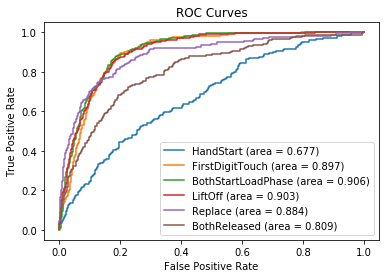

49069 49069
Train subject 10, class HandStart
Train on 1944 samples, validate on 486 samples
Epoch 1/100
1944/1944 [==============================] - 1s 733us/step - loss: 0.6973 - acc: 0.5005 - val_loss: 0.6920 - val_acc: 0.5123
Epoch 2/100
1944/1944 [==============================] - 1s 362us/step - loss: 0.6962 - acc: 0.5051 - val_loss: 0.6913 - val_acc: 0.5185
Epoch 3/100
1944/1944 [==============================] - 1s 358us/step - loss: 0.6957 - acc: 0.4928 - val_loss: 0.6907 - val_acc: 0.5329
Epoch 4/100
1944/1944 [==============================] - 1s 350us/step - loss: 0.6946 - acc: 0.5098 - val_loss: 0.6902 - val_acc: 0.5741
Epoch 5/100
1944/1944 [==============================] - 1s 361us/step - loss: 0.6955 - acc: 0.5072 - val_loss: 0.6898 - val_acc: 0.5556
Epoch 6/100
1944/1944 [==============================] - 1s 380us/step - loss: 0.6936 - acc: 0.5206 - val_loss: 0.6893 - val_acc: 0.5556
Epoch 7/100
1944/1944 [==============================] - 1s 411us/step - loss: 0.6928

1944/1944 [==============================] - 1s 340us/step - loss: 0.6423 - acc: 0.6641 - val_loss: 0.6333 - val_acc: 0.6934
Epoch 60/100
1944/1944 [==============================] - 1s 345us/step - loss: 0.6443 - acc: 0.6553 - val_loss: 0.6306 - val_acc: 0.6955
Epoch 61/100
1944/1944 [==============================] - 1s 344us/step - loss: 0.6399 - acc: 0.6759 - val_loss: 0.6278 - val_acc: 0.6975
Epoch 62/100
1944/1944 [==============================] - 1s 331us/step - loss: 0.6352 - acc: 0.6852 - val_loss: 0.6249 - val_acc: 0.6996
Epoch 63/100
1944/1944 [==============================] - 1s 330us/step - loss: 0.6344 - acc: 0.6662 - val_loss: 0.6218 - val_acc: 0.6996
Epoch 64/100
1944/1944 [==============================] - 1s 331us/step - loss: 0.6314 - acc: 0.6713 - val_loss: 0.6186 - val_acc: 0.6975
Epoch 65/100
1944/1944 [==============================] - 1s 337us/step - loss: 0.6227 - acc: 0.6857 - val_loss: 0.6154 - val_acc: 0.6996
Epoch 66/100
1944/1944 [=======================

1944/1944 [==============================] - 1s 342us/step - loss: 0.5416 - acc: 0.7248 - val_loss: 0.5143 - val_acc: 0.7346
Epoch 19/100
1944/1944 [==============================] - 1s 357us/step - loss: 0.5451 - acc: 0.7212 - val_loss: 0.5119 - val_acc: 0.7387
Epoch 20/100
1944/1944 [==============================] - 1s 349us/step - loss: 0.5425 - acc: 0.7227 - val_loss: 0.5127 - val_acc: 0.7305
Epoch 21/100
1944/1944 [==============================] - 1s 342us/step - loss: 0.5376 - acc: 0.7279 - val_loss: 0.5091 - val_acc: 0.7387
Epoch 22/100
1944/1944 [==============================] - 1s 337us/step - loss: 0.5407 - acc: 0.7233 - val_loss: 0.5092 - val_acc: 0.7387
Epoch 23/100
1944/1944 [==============================] - 1s 342us/step - loss: 0.5432 - acc: 0.7176 - val_loss: 0.5064 - val_acc: 0.7449
Epoch 24/100
1944/1944 [==============================] - 1s 357us/step - loss: 0.5386 - acc: 0.7233 - val_loss: 0.5085 - val_acc: 0.7407
Epoch 25/100
1944/1944 [=======================

1944/1944 [==============================] - 1s 345us/step - loss: 0.4672 - acc: 0.7659 - val_loss: 0.4465 - val_acc: 0.7963
Epoch 78/100
1944/1944 [==============================] - 1s 342us/step - loss: 0.4647 - acc: 0.7762 - val_loss: 0.4482 - val_acc: 0.7963
Epoch 79/100
1944/1944 [==============================] - 1s 358us/step - loss: 0.4664 - acc: 0.7685 - val_loss: 0.4445 - val_acc: 0.7984
Epoch 80/100
1944/1944 [==============================] - 1s 350us/step - loss: 0.4617 - acc: 0.7695 - val_loss: 0.4443 - val_acc: 0.7984
Epoch 81/100
1944/1944 [==============================] - 1s 350us/step - loss: 0.4653 - acc: 0.7716 - val_loss: 0.4483 - val_acc: 0.7984
Epoch 82/100
1944/1944 [==============================] - 1s 341us/step - loss: 0.4636 - acc: 0.7665 - val_loss: 0.4461 - val_acc: 0.8025
Epoch 83/100
1944/1944 [==============================] - 1s 343us/step - loss: 0.4634 - acc: 0.7726 - val_loss: 0.4414 - val_acc: 0.8025
Epoch 84/100
1944/1944 [=======================

1944/1944 [==============================] - 1s 354us/step - loss: 0.6561 - acc: 0.6456 - val_loss: 0.6452 - val_acc: 0.6934
Epoch 36/100
1944/1944 [==============================] - 1s 345us/step - loss: 0.6536 - acc: 0.6641 - val_loss: 0.6423 - val_acc: 0.6914
Epoch 37/100
1944/1944 [==============================] - 1s 352us/step - loss: 0.6481 - acc: 0.6759 - val_loss: 0.6383 - val_acc: 0.6975
Epoch 38/100
1944/1944 [==============================] - 1s 349us/step - loss: 0.6424 - acc: 0.6821 - val_loss: 0.6347 - val_acc: 0.6975
Epoch 39/100
1944/1944 [==============================] - 1s 349us/step - loss: 0.6444 - acc: 0.6728 - val_loss: 0.6307 - val_acc: 0.6996
Epoch 40/100
1944/1944 [==============================] - 1s 345us/step - loss: 0.6401 - acc: 0.6744 - val_loss: 0.6263 - val_acc: 0.7058
Epoch 41/100
1944/1944 [==============================] - 1s 348us/step - loss: 0.6365 - acc: 0.6821 - val_loss: 0.6210 - val_acc: 0.7078
Epoch 42/100
1944/1944 [=======================

1944/1944 [==============================] - 1s 345us/step - loss: 0.3550 - acc: 0.8565 - val_loss: 0.3106 - val_acc: 0.8951
Epoch 95/100
1944/1944 [==============================] - 1s 346us/step - loss: 0.3481 - acc: 0.8498 - val_loss: 0.3110 - val_acc: 0.8909
Epoch 96/100
1944/1944 [==============================] - 1s 344us/step - loss: 0.3500 - acc: 0.8513 - val_loss: 0.3109 - val_acc: 0.8868
Epoch 97/100
1944/1944 [==============================] - 1s 343us/step - loss: 0.3416 - acc: 0.8529 - val_loss: 0.3093 - val_acc: 0.8868
Epoch 98/100
1944/1944 [==============================] - 1s 347us/step - loss: 0.3447 - acc: 0.8575 - val_loss: 0.3052 - val_acc: 0.8971
Epoch 99/100
1944/1944 [==============================] - 1s 353us/step - loss: 0.3371 - acc: 0.8508 - val_loss: 0.3045 - val_acc: 0.8951
Epoch 100/100
1944/1944 [==============================] - 1s 342us/step - loss: 0.3356 - acc: 0.8575 - val_loss: 0.3045 - val_acc: 0.8909
Train on 1944 samples, validate on 486 samples

1944/1944 [==============================] - 1s 343us/step - loss: 0.2736 - acc: 0.9012 - val_loss: 0.2816 - val_acc: 0.8971
Epoch 54/100
1944/1944 [==============================] - 1s 346us/step - loss: 0.2717 - acc: 0.9017 - val_loss: 0.2789 - val_acc: 0.8992
Epoch 55/100
1944/1944 [==============================] - 1s 339us/step - loss: 0.2721 - acc: 0.8945 - val_loss: 0.2809 - val_acc: 0.8992
Epoch 56/100
1944/1944 [==============================] - 1s 339us/step - loss: 0.2733 - acc: 0.9002 - val_loss: 0.2783 - val_acc: 0.8992
Epoch 57/100
1944/1944 [==============================] - 1s 339us/step - loss: 0.2793 - acc: 0.8987 - val_loss: 0.2768 - val_acc: 0.8992
Epoch 58/100
1944/1944 [==============================] - 1s 329us/step - loss: 0.2720 - acc: 0.9053 - val_loss: 0.2777 - val_acc: 0.8992
Epoch 59/100
1944/1944 [==============================] - 1s 353us/step - loss: 0.2684 - acc: 0.9028 - val_loss: 0.2783 - val_acc: 0.8992
Epoch 60/100
1944/1944 [=======================

1944/1944 [==============================] - 1s 334us/step - loss: 0.6907 - acc: 0.5185 - val_loss: 0.6895 - val_acc: 0.5988
Epoch 12/100
1944/1944 [==============================] - 1s 338us/step - loss: 0.6903 - acc: 0.5221 - val_loss: 0.6889 - val_acc: 0.6235
Epoch 13/100
1944/1944 [==============================] - 1s 335us/step - loss: 0.6895 - acc: 0.5432 - val_loss: 0.6884 - val_acc: 0.6214
Epoch 14/100
1944/1944 [==============================] - 1s 334us/step - loss: 0.6888 - acc: 0.5535 - val_loss: 0.6879 - val_acc: 0.6152
Epoch 15/100
1944/1944 [==============================] - 1s 334us/step - loss: 0.6875 - acc: 0.5612 - val_loss: 0.6874 - val_acc: 0.6111
Epoch 16/100
1944/1944 [==============================] - 1s 353us/step - loss: 0.6887 - acc: 0.5504 - val_loss: 0.6869 - val_acc: 0.6111
Epoch 17/100
1944/1944 [==============================] - 1s 362us/step - loss: 0.6879 - acc: 0.5612 - val_loss: 0.6863 - val_acc: 0.6193
Epoch 18/100
1944/1944 [=======================

1944/1944 [==============================] - 1s 361us/step - loss: 0.5053 - acc: 0.8225 - val_loss: 0.4835 - val_acc: 0.8354
Epoch 71/100
1944/1944 [==============================] - 1s 360us/step - loss: 0.4983 - acc: 0.8122 - val_loss: 0.4706 - val_acc: 0.8354
Epoch 72/100
1944/1944 [==============================] - 1s 342us/step - loss: 0.4812 - acc: 0.8333 - val_loss: 0.4570 - val_acc: 0.8416
Epoch 73/100
1944/1944 [==============================] - 1s 340us/step - loss: 0.4755 - acc: 0.8174 - val_loss: 0.4424 - val_acc: 0.8477
Epoch 74/100
1944/1944 [==============================] - 1s 340us/step - loss: 0.4604 - acc: 0.8395 - val_loss: 0.4326 - val_acc: 0.8436
Epoch 75/100
1944/1944 [==============================] - 1s 353us/step - loss: 0.4516 - acc: 0.8344 - val_loss: 0.4207 - val_acc: 0.8457
Epoch 76/100
1944/1944 [==============================] - 1s 333us/step - loss: 0.4448 - acc: 0.8236 - val_loss: 0.4110 - val_acc: 0.8416
Epoch 77/100
1944/1944 [=======================

1944/1944 [==============================] - 1s 341us/step - loss: 0.3092 - acc: 0.8997 - val_loss: 0.2873 - val_acc: 0.8827
Epoch 30/100
1944/1944 [==============================] - 1s 349us/step - loss: 0.3042 - acc: 0.9038 - val_loss: 0.2868 - val_acc: 0.8827
Epoch 31/100
1944/1944 [==============================] - 1s 343us/step - loss: 0.3214 - acc: 0.8940 - val_loss: 0.2857 - val_acc: 0.8848
Epoch 32/100
1944/1944 [==============================] - 1s 343us/step - loss: 0.3074 - acc: 0.8956 - val_loss: 0.2854 - val_acc: 0.8848
Epoch 33/100
1944/1944 [==============================] - 1s 345us/step - loss: 0.3023 - acc: 0.9038 - val_loss: 0.2849 - val_acc: 0.8889
Epoch 34/100
1944/1944 [==============================] - 1s 352us/step - loss: 0.3051 - acc: 0.9048 - val_loss: 0.2834 - val_acc: 0.8868
Epoch 35/100
1944/1944 [==============================] - 1s 354us/step - loss: 0.3098 - acc: 0.8935 - val_loss: 0.2833 - val_acc: 0.8889
Epoch 36/100
1944/1944 [=======================

1944/1944 [==============================] - 1s 335us/step - loss: 0.2759 - acc: 0.9095 - val_loss: 0.2539 - val_acc: 0.9033
Epoch 89/100
1944/1944 [==============================] - 1s 350us/step - loss: 0.2714 - acc: 0.9187 - val_loss: 0.2530 - val_acc: 0.9033
Epoch 90/100
1944/1944 [==============================] - 1s 345us/step - loss: 0.2727 - acc: 0.9172 - val_loss: 0.2535 - val_acc: 0.9095
Epoch 91/100
1944/1944 [==============================] - 1s 350us/step - loss: 0.2824 - acc: 0.9120 - val_loss: 0.2543 - val_acc: 0.9095
Epoch 92/100
1944/1944 [==============================] - 1s 375us/step - loss: 0.2680 - acc: 0.9167 - val_loss: 0.2521 - val_acc: 0.9033
Epoch 93/100
1944/1944 [==============================] - 1s 379us/step - loss: 0.2706 - acc: 0.9167 - val_loss: 0.2522 - val_acc: 0.9115
Epoch 94/100
1944/1944 [==============================] - 1s 367us/step - loss: 0.2690 - acc: 0.9115 - val_loss: 0.2528 - val_acc: 0.9136
Epoch 95/100
1944/1944 [=======================

1944/1944 [==============================] - 1s 342us/step - loss: 0.6839 - acc: 0.5957 - val_loss: 0.6822 - val_acc: 0.6255
Epoch 47/100
1944/1944 [==============================] - 1s 339us/step - loss: 0.6834 - acc: 0.6044 - val_loss: 0.6817 - val_acc: 0.6296
Epoch 48/100
1944/1944 [==============================] - 1s 343us/step - loss: 0.6849 - acc: 0.5900 - val_loss: 0.6812 - val_acc: 0.6317
Epoch 49/100
1944/1944 [==============================] - 1s 343us/step - loss: 0.6840 - acc: 0.5998 - val_loss: 0.6807 - val_acc: 0.6337
Epoch 50/100
1944/1944 [==============================] - 1s 343us/step - loss: 0.6814 - acc: 0.6065 - val_loss: 0.6802 - val_acc: 0.6337
Epoch 51/100
1944/1944 [==============================] - 1s 342us/step - loss: 0.6810 - acc: 0.6121 - val_loss: 0.6796 - val_acc: 0.6358
Epoch 52/100
1944/1944 [==============================] - 1s 343us/step - loss: 0.6810 - acc: 0.6116 - val_loss: 0.6790 - val_acc: 0.6379
Epoch 53/100
1944/1944 [=======================

1944/1944 [==============================] - 1s 345us/step - loss: 0.5413 - acc: 0.7474 - val_loss: 0.5448 - val_acc: 0.7428
Epoch 6/100
1944/1944 [==============================] - 1s 340us/step - loss: 0.5377 - acc: 0.7469 - val_loss: 0.5383 - val_acc: 0.7449
Epoch 7/100
1944/1944 [==============================] - 1s 353us/step - loss: 0.5292 - acc: 0.7541 - val_loss: 0.5318 - val_acc: 0.7407
Epoch 8/100
1944/1944 [==============================] - 1s 351us/step - loss: 0.5217 - acc: 0.7608 - val_loss: 0.5248 - val_acc: 0.7469
Epoch 9/100
1944/1944 [==============================] - 1s 352us/step - loss: 0.5078 - acc: 0.7737 - val_loss: 0.5182 - val_acc: 0.7428
Epoch 10/100
1944/1944 [==============================] - 1s 345us/step - loss: 0.5013 - acc: 0.7783 - val_loss: 0.5112 - val_acc: 0.7490
Epoch 11/100
1944/1944 [==============================] - 1s 354us/step - loss: 0.4982 - acc: 0.7809 - val_loss: 0.5049 - val_acc: 0.7490
Epoch 12/100
1944/1944 [===========================

1944/1944 [==============================] - 1s 344us/step - loss: 0.3195 - acc: 0.8729 - val_loss: 0.3386 - val_acc: 0.8601
Epoch 65/100
1944/1944 [==============================] - 1s 340us/step - loss: 0.3171 - acc: 0.8745 - val_loss: 0.3390 - val_acc: 0.8663
Epoch 66/100
1944/1944 [==============================] - 1s 346us/step - loss: 0.3254 - acc: 0.8740 - val_loss: 0.3386 - val_acc: 0.8642
Epoch 67/100
1944/1944 [==============================] - 1s 341us/step - loss: 0.3125 - acc: 0.8776 - val_loss: 0.3370 - val_acc: 0.8663
Epoch 68/100
1944/1944 [==============================] - 1s 362us/step - loss: 0.3144 - acc: 0.8704 - val_loss: 0.3333 - val_acc: 0.8621
Epoch 69/100
1944/1944 [==============================] - 1s 345us/step - loss: 0.3129 - acc: 0.8765 - val_loss: 0.3322 - val_acc: 0.8621
Epoch 70/100
1944/1944 [==============================] - 1s 341us/step - loss: 0.3177 - acc: 0.8735 - val_loss: 0.3329 - val_acc: 0.8663
Epoch 71/100
1944/1944 [=======================

Epoch 23/100
1944/1944 [==============================] - 1s 339us/step - loss: 0.6869 - acc: 0.5705 - val_loss: 0.6824 - val_acc: 0.6440
Epoch 24/100
1944/1944 [==============================] - 1s 348us/step - loss: 0.6876 - acc: 0.5566 - val_loss: 0.6820 - val_acc: 0.6502
Epoch 25/100
1944/1944 [==============================] - 1s 345us/step - loss: 0.6863 - acc: 0.5710 - val_loss: 0.6813 - val_acc: 0.6626
Epoch 26/100
1944/1944 [==============================] - 1s 358us/step - loss: 0.6873 - acc: 0.5638 - val_loss: 0.6808 - val_acc: 0.6564
Epoch 27/100
1944/1944 [==============================] - 1s 341us/step - loss: 0.6847 - acc: 0.5694 - val_loss: 0.6802 - val_acc: 0.6543
Epoch 28/100
1944/1944 [==============================] - 1s 346us/step - loss: 0.6849 - acc: 0.5838 - val_loss: 0.6795 - val_acc: 0.6584
Epoch 29/100
1944/1944 [==============================] - 1s 345us/step - loss: 0.6849 - acc: 0.5880 - val_loss: 0.6787 - val_acc: 0.6687
Epoch 30/100
1944/1944 [==========

1944/1944 [==============================] - 1s 359us/step - loss: 0.5487 - acc: 0.7454 - val_loss: 0.5215 - val_acc: 0.7675
Epoch 83/100
1944/1944 [==============================] - 1s 377us/step - loss: 0.5413 - acc: 0.7454 - val_loss: 0.5180 - val_acc: 0.7675
Epoch 84/100
1944/1944 [==============================] - 1s 360us/step - loss: 0.5382 - acc: 0.7474 - val_loss: 0.5147 - val_acc: 0.7716
Epoch 85/100
1944/1944 [==============================] - 1s 376us/step - loss: 0.5346 - acc: 0.7510 - val_loss: 0.5076 - val_acc: 0.7695
Epoch 86/100
1944/1944 [==============================] - 1s 381us/step - loss: 0.5308 - acc: 0.7546 - val_loss: 0.5042 - val_acc: 0.7716
Epoch 87/100
1944/1944 [==============================] - 1s 361us/step - loss: 0.5253 - acc: 0.7495 - val_loss: 0.5004 - val_acc: 0.7716
Epoch 88/100
1944/1944 [==============================] - 1s 351us/step - loss: 0.5191 - acc: 0.7557 - val_loss: 0.4993 - val_acc: 0.7716
Epoch 89/100
1944/1944 [=======================

1944/1944 [==============================] - 1s 344us/step - loss: 0.3531 - acc: 0.8431 - val_loss: 0.3324 - val_acc: 0.8642
Epoch 42/100
1944/1944 [==============================] - 1s 345us/step - loss: 0.3460 - acc: 0.8513 - val_loss: 0.3326 - val_acc: 0.8601
Epoch 43/100
1944/1944 [==============================] - 1s 341us/step - loss: 0.3420 - acc: 0.8539 - val_loss: 0.3291 - val_acc: 0.8621
Epoch 44/100
1944/1944 [==============================] - 1s 349us/step - loss: 0.3440 - acc: 0.8493 - val_loss: 0.3282 - val_acc: 0.8601
Epoch 45/100
1944/1944 [==============================] - 1s 340us/step - loss: 0.3446 - acc: 0.8549 - val_loss: 0.3255 - val_acc: 0.8663
Epoch 46/100
1944/1944 [==============================] - 1s 343us/step - loss: 0.3385 - acc: 0.8549 - val_loss: 0.3250 - val_acc: 0.8642
Epoch 47/100
1944/1944 [==============================] - 1s 349us/step - loss: 0.3331 - acc: 0.8524 - val_loss: 0.3213 - val_acc: 0.8663
Epoch 48/100
1944/1944 [=======================

1944/1944 [==============================] - 1s 336us/step - loss: 0.2486 - acc: 0.8997 - val_loss: 0.2652 - val_acc: 0.9033
Test subject 10, class Replace
Train subject 10, class BothReleased
Train on 1944 samples, validate on 486 samples
Epoch 1/100
1944/1944 [==============================] - 2s 836us/step - loss: 0.6915 - acc: 0.5262 - val_loss: 0.6927 - val_acc: 0.5412
Epoch 2/100
1944/1944 [==============================] - 1s 354us/step - loss: 0.6925 - acc: 0.5108 - val_loss: 0.6920 - val_acc: 0.5473
Epoch 3/100
1944/1944 [==============================] - 1s 349us/step - loss: 0.6924 - acc: 0.5093 - val_loss: 0.6915 - val_acc: 0.5556
Epoch 4/100
1944/1944 [==============================] - 1s 347us/step - loss: 0.6920 - acc: 0.5165 - val_loss: 0.6911 - val_acc: 0.5638
Epoch 5/100
1944/1944 [==============================] - 1s 359us/step - loss: 0.6904 - acc: 0.5303 - val_loss: 0.6906 - val_acc: 0.5617
Epoch 6/100
1944/1944 [==============================] - 1s 354us/step - lo

Epoch 59/100
1944/1944 [==============================] - 1s 350us/step - loss: 0.5918 - acc: 0.7387 - val_loss: 0.5909 - val_acc: 0.7284
Epoch 60/100
1944/1944 [==============================] - 1s 346us/step - loss: 0.5876 - acc: 0.7356 - val_loss: 0.5854 - val_acc: 0.7305
Epoch 61/100
1944/1944 [==============================] - 1s 350us/step - loss: 0.5809 - acc: 0.7428 - val_loss: 0.5792 - val_acc: 0.7263
Epoch 62/100
1944/1944 [==============================] - 1s 354us/step - loss: 0.5709 - acc: 0.7371 - val_loss: 0.5733 - val_acc: 0.7263
Epoch 63/100
1944/1944 [==============================] - 1s 346us/step - loss: 0.5653 - acc: 0.7407 - val_loss: 0.5679 - val_acc: 0.7284
Epoch 64/100
1944/1944 [==============================] - 1s 350us/step - loss: 0.5576 - acc: 0.7443 - val_loss: 0.5612 - val_acc: 0.7305
Epoch 65/100
1944/1944 [==============================] - 1s 346us/step - loss: 0.5497 - acc: 0.7567 - val_loss: 0.5547 - val_acc: 0.7366
Epoch 66/100
1944/1944 [==========

1944/1944 [==============================] - 1s 358us/step - loss: 0.3545 - acc: 0.8436 - val_loss: 0.3211 - val_acc: 0.8724
Epoch 19/100
1944/1944 [==============================] - 1s 390us/step - loss: 0.3604 - acc: 0.8410 - val_loss: 0.3203 - val_acc: 0.8786
Epoch 20/100
1944/1944 [==============================] - 1s 349us/step - loss: 0.3565 - acc: 0.8447 - val_loss: 0.3188 - val_acc: 0.8786
Epoch 21/100
1944/1944 [==============================] - 1s 352us/step - loss: 0.3492 - acc: 0.8529 - val_loss: 0.3211 - val_acc: 0.8745
Epoch 22/100
1944/1944 [==============================] - 1s 357us/step - loss: 0.3588 - acc: 0.8400 - val_loss: 0.3157 - val_acc: 0.8786
Epoch 23/100
1944/1944 [==============================] - 1s 360us/step - loss: 0.3450 - acc: 0.8447 - val_loss: 0.3171 - val_acc: 0.8765
Epoch 24/100
1944/1944 [==============================] - 1s 365us/step - loss: 0.3512 - acc: 0.8508 - val_loss: 0.3112 - val_acc: 0.8786
Epoch 25/100
1944/1944 [=======================

1944/1944 [==============================] - 1s 353us/step - loss: 0.2905 - acc: 0.8873 - val_loss: 0.2717 - val_acc: 0.8930
Epoch 78/100
1944/1944 [==============================] - 1s 345us/step - loss: 0.2915 - acc: 0.8848 - val_loss: 0.2728 - val_acc: 0.8930
Epoch 79/100
1944/1944 [==============================] - 1s 340us/step - loss: 0.2926 - acc: 0.8822 - val_loss: 0.2757 - val_acc: 0.8930
Epoch 80/100
1944/1944 [==============================] - 1s 351us/step - loss: 0.2804 - acc: 0.8879 - val_loss: 0.2802 - val_acc: 0.8889
Epoch 81/100
1944/1944 [==============================] - 1s 359us/step - loss: 0.2892 - acc: 0.8827 - val_loss: 0.2732 - val_acc: 0.8930
Epoch 82/100
1944/1944 [==============================] - 1s 345us/step - loss: 0.2896 - acc: 0.8796 - val_loss: 0.2762 - val_acc: 0.8889
Epoch 83/100
1944/1944 [==============================] - 1s 350us/step - loss: 0.2893 - acc: 0.8801 - val_loss: 0.2756 - val_acc: 0.8930
Epoch 84/100
1944/1944 [=======================

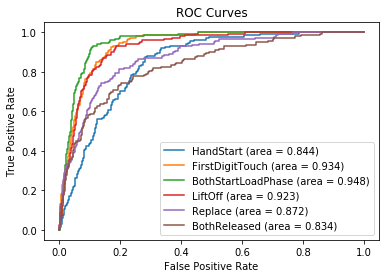

50195 50195
Train subject 11, class HandStart
Train on 1956 samples, validate on 489 samples
Epoch 1/100
1956/1956 [==============================] - 2s 960us/step - loss: 0.6956 - acc: 0.5072 - val_loss: 0.6918 - val_acc: 0.5194
Epoch 2/100
1956/1956 [==============================] - 1s 338us/step - loss: 0.6948 - acc: 0.4934 - val_loss: 0.6917 - val_acc: 0.5440
Epoch 3/100
1956/1956 [==============================] - 1s 345us/step - loss: 0.6946 - acc: 0.5056 - val_loss: 0.6916 - val_acc: 0.5583
Epoch 4/100
1956/1956 [==============================] - 1s 342us/step - loss: 0.6959 - acc: 0.5026 - val_loss: 0.6916 - val_acc: 0.5215
Epoch 5/100
1956/1956 [==============================] - 1s 344us/step - loss: 0.6936 - acc: 0.5143 - val_loss: 0.6914 - val_acc: 0.5256
Epoch 6/100
1956/1956 [==============================] - 1s 343us/step - loss: 0.6956 - acc: 0.5123 - val_loss: 0.6914 - val_acc: 0.5215
Epoch 7/100
1956/1956 [==============================] - 1s 347us/step - loss: 0.6914

Epoch 60/100
1956/1956 [==============================] - 1s 343us/step - loss: 0.6814 - acc: 0.5741 - val_loss: 0.6777 - val_acc: 0.5706
Epoch 61/100
1956/1956 [==============================] - 1s 341us/step - loss: 0.6785 - acc: 0.5833 - val_loss: 0.6772 - val_acc: 0.5746
Epoch 62/100
1956/1956 [==============================] - 1s 344us/step - loss: 0.6805 - acc: 0.5670 - val_loss: 0.6767 - val_acc: 0.5787
Epoch 63/100
1956/1956 [==============================] - 1s 346us/step - loss: 0.6816 - acc: 0.5721 - val_loss: 0.6760 - val_acc: 0.5808
Epoch 64/100
1956/1956 [==============================] - 1s 350us/step - loss: 0.6789 - acc: 0.5844 - val_loss: 0.6753 - val_acc: 0.5849
Epoch 65/100
1956/1956 [==============================] - ETA: 0s - loss: 0.6782 - acc: 0.576 - 1s 353us/step - loss: 0.6781 - acc: 0.5746 - val_loss: 0.6744 - val_acc: 0.5910
Epoch 66/100
1956/1956 [==============================] - 1s 350us/step - loss: 0.6761 - acc: 0.5890 - val_loss: 0.6743 - val_acc: 0.5

Epoch 19/100
1956/1956 [==============================] - 1s 362us/step - loss: 0.6641 - acc: 0.5930 - val_loss: 0.6712 - val_acc: 0.6176
Epoch 20/100
1956/1956 [==============================] - 1s 347us/step - loss: 0.6619 - acc: 0.5915 - val_loss: 0.6706 - val_acc: 0.6217
Epoch 21/100
1956/1956 [==============================] - 1s 350us/step - loss: 0.6625 - acc: 0.5849 - val_loss: 0.6712 - val_acc: 0.6217
Epoch 22/100
1956/1956 [==============================] - 1s 346us/step - loss: 0.6581 - acc: 0.6017 - val_loss: 0.6700 - val_acc: 0.6237
Epoch 23/100
1956/1956 [==============================] - 1s 348us/step - loss: 0.6629 - acc: 0.5828 - val_loss: 0.6681 - val_acc: 0.6258
Epoch 24/100
1956/1956 [==============================] - 1s 358us/step - loss: 0.6624 - acc: 0.5961 - val_loss: 0.6700 - val_acc: 0.6217
Epoch 25/100
1956/1956 [==============================] - 1s 351us/step - loss: 0.6612 - acc: 0.5997 - val_loss: 0.6675 - val_acc: 0.6299
Epoch 26/100
1956/1956 [==========

1956/1956 [==============================] - 1s 349us/step - loss: 0.6308 - acc: 0.6488 - val_loss: 0.6425 - val_acc: 0.6360
Epoch 79/100
1956/1956 [==============================] - 1s 346us/step - loss: 0.6275 - acc: 0.6380 - val_loss: 0.6403 - val_acc: 0.6503
Epoch 80/100
1956/1956 [==============================] - 1s 350us/step - loss: 0.6223 - acc: 0.6524 - val_loss: 0.6407 - val_acc: 0.6462
Epoch 81/100
1956/1956 [==============================] - 1s 344us/step - loss: 0.6235 - acc: 0.6431 - val_loss: 0.6408 - val_acc: 0.6462
Epoch 82/100
1956/1956 [==============================] - 1s 344us/step - loss: 0.6290 - acc: 0.6375 - val_loss: 0.6427 - val_acc: 0.6401
Epoch 83/100
1956/1956 [==============================] - 1s 341us/step - loss: 0.6257 - acc: 0.6421 - val_loss: 0.6426 - val_acc: 0.6401
Epoch 84/100
1956/1956 [==============================] - 1s 361us/step - loss: 0.6259 - acc: 0.6442 - val_loss: 0.6438 - val_acc: 0.6380
Epoch 85/100
1956/1956 [=======================

1956/1956 [==============================] - 1s 355us/step - loss: 0.6387 - acc: 0.6713 - val_loss: 0.6209 - val_acc: 0.7157
Epoch 37/100
1956/1956 [==============================] - 1s 350us/step - loss: 0.6353 - acc: 0.6672 - val_loss: 0.6151 - val_acc: 0.7280
Epoch 38/100
1956/1956 [==============================] - 1s 352us/step - loss: 0.6277 - acc: 0.6876 - val_loss: 0.6096 - val_acc: 0.7301
Epoch 39/100
1956/1956 [==============================] - 1s 351us/step - loss: 0.6335 - acc: 0.6851 - val_loss: 0.6032 - val_acc: 0.7464
Epoch 40/100
1956/1956 [==============================] - 1s 355us/step - loss: 0.6227 - acc: 0.6892 - val_loss: 0.5975 - val_acc: 0.7301
Epoch 41/100
1956/1956 [==============================] - 1s 355us/step - loss: 0.6185 - acc: 0.6999 - val_loss: 0.5927 - val_acc: 0.7198
Epoch 42/100
1956/1956 [==============================] - 1s 347us/step - loss: 0.6121 - acc: 0.7091 - val_loss: 0.5847 - val_acc: 0.7239
Epoch 43/100
1956/1956 [=======================

1956/1956 [==============================] - 1s 356us/step - loss: 0.3991 - acc: 0.8241 - val_loss: 0.3881 - val_acc: 0.8282
Epoch 96/100
1956/1956 [==============================] - 1s 352us/step - loss: 0.3962 - acc: 0.8287 - val_loss: 0.3868 - val_acc: 0.8241
Epoch 97/100
1956/1956 [==============================] - 1s 354us/step - loss: 0.3966 - acc: 0.8298 - val_loss: 0.3873 - val_acc: 0.8262
Epoch 98/100
1956/1956 [==============================] - 1s 351us/step - loss: 0.3903 - acc: 0.8287 - val_loss: 0.3847 - val_acc: 0.8241
Epoch 99/100
1956/1956 [==============================] - 1s 358us/step - loss: 0.3926 - acc: 0.8267 - val_loss: 0.3859 - val_acc: 0.8241
Epoch 100/100
1956/1956 [==============================] - 1s 365us/step - loss: 0.3918 - acc: 0.8308 - val_loss: 0.3829 - val_acc: 0.8241
Train on 1956 samples, validate on 489 samples
Epoch 1/100
1956/1956 [==============================] - 1s 359us/step - loss: 0.4322 - acc: 0.8027 - val_loss: 0.4335 - val_acc: 0.8016


1956/1956 [==============================] - 1s 361us/step - loss: 0.3736 - acc: 0.8364 - val_loss: 0.3938 - val_acc: 0.8139
Epoch 55/100
1956/1956 [==============================] - 1s 354us/step - loss: 0.3732 - acc: 0.8405 - val_loss: 0.3910 - val_acc: 0.8180
Epoch 56/100
1956/1956 [==============================] - 1s 356us/step - loss: 0.3780 - acc: 0.8328 - val_loss: 0.3914 - val_acc: 0.8180
Epoch 57/100
1956/1956 [==============================] - 1s 360us/step - loss: 0.3740 - acc: 0.8303 - val_loss: 0.3908 - val_acc: 0.8180
Epoch 58/100
1956/1956 [==============================] - 1s 352us/step - loss: 0.3733 - acc: 0.8405 - val_loss: 0.3889 - val_acc: 0.8221
Epoch 59/100
1956/1956 [==============================] - 1s 371us/step - loss: 0.3811 - acc: 0.8308 - val_loss: 0.3898 - val_acc: 0.8200
Epoch 60/100
1956/1956 [==============================] - 1s 355us/step - loss: 0.3762 - acc: 0.8364 - val_loss: 0.3877 - val_acc: 0.8221
Epoch 61/100
1956/1956 [=======================

1955/1955 [==============================] - 1s 355us/step - loss: 0.6894 - acc: 0.5371 - val_loss: 0.6891 - val_acc: 0.5910
Epoch 13/100
1955/1955 [==============================] - 1s 348us/step - loss: 0.6927 - acc: 0.5217 - val_loss: 0.6887 - val_acc: 0.5849
Epoch 14/100
1955/1955 [==============================] - 1s 352us/step - loss: 0.6904 - acc: 0.5320 - val_loss: 0.6885 - val_acc: 0.5992
Epoch 15/100
1955/1955 [==============================] - 1s 351us/step - loss: 0.6912 - acc: 0.5212 - val_loss: 0.6882 - val_acc: 0.5849
Epoch 16/100
1955/1955 [==============================] - 1s 360us/step - loss: 0.6915 - acc: 0.5304 - val_loss: 0.6880 - val_acc: 0.5787
Epoch 17/100
1955/1955 [==============================] - 1s 352us/step - loss: 0.6897 - acc: 0.5361 - val_loss: 0.6878 - val_acc: 0.5869
Epoch 18/100
1955/1955 [==============================] - 1s 354us/step - loss: 0.6883 - acc: 0.5529 - val_loss: 0.6877 - val_acc: 0.5951
Epoch 19/100
1955/1955 [=======================

1955/1955 [==============================] - 1s 353us/step - loss: 0.6238 - acc: 0.7023 - val_loss: 0.6345 - val_acc: 0.6667
Epoch 72/100
1955/1955 [==============================] - 1s 351us/step - loss: 0.6221 - acc: 0.7038 - val_loss: 0.6314 - val_acc: 0.6626
Epoch 73/100
1955/1955 [==============================] - 1s 365us/step - loss: 0.6178 - acc: 0.7090 - val_loss: 0.6284 - val_acc: 0.6646
Epoch 74/100
1955/1955 [==============================] - 1s 356us/step - loss: 0.6162 - acc: 0.7125 - val_loss: 0.6256 - val_acc: 0.6667
Epoch 75/100
1955/1955 [==============================] - 1s 360us/step - loss: 0.6118 - acc: 0.7095 - val_loss: 0.6224 - val_acc: 0.6646
Epoch 76/100
1955/1955 [==============================] - 1s 353us/step - loss: 0.6069 - acc: 0.7269 - val_loss: 0.6189 - val_acc: 0.6646
Epoch 77/100
1955/1955 [==============================] - 1s 358us/step - loss: 0.6070 - acc: 0.7166 - val_loss: 0.6155 - val_acc: 0.6667
Epoch 78/100
1955/1955 [=======================

1955/1955 [==============================] - 1s 350us/step - loss: 0.4595 - acc: 0.7934 - val_loss: 0.4410 - val_acc: 0.7955
Epoch 31/100
1955/1955 [==============================] - 1s 359us/step - loss: 0.4592 - acc: 0.7872 - val_loss: 0.4420 - val_acc: 0.8016
Epoch 32/100
1955/1955 [==============================] - 1s 353us/step - loss: 0.4574 - acc: 0.7980 - val_loss: 0.4399 - val_acc: 0.7996
Epoch 33/100
1955/1955 [==============================] - 1s 374us/step - loss: 0.4511 - acc: 0.8010 - val_loss: 0.4389 - val_acc: 0.7996
Epoch 34/100
1955/1955 [==============================] - 1s 349us/step - loss: 0.4409 - acc: 0.8015 - val_loss: 0.4374 - val_acc: 0.7975
Epoch 35/100
1955/1955 [==============================] - 1s 350us/step - loss: 0.4540 - acc: 0.7980 - val_loss: 0.4370 - val_acc: 0.8016
Epoch 36/100
1955/1955 [==============================] - 1s 351us/step - loss: 0.4467 - acc: 0.7995 - val_loss: 0.4364 - val_acc: 0.8016
Epoch 37/100
1955/1955 [=======================

1955/1955 [==============================] - 1s 352us/step - loss: 0.3974 - acc: 0.8302 - val_loss: 0.3970 - val_acc: 0.8364
Epoch 90/100
1955/1955 [==============================] - 1s 358us/step - loss: 0.4001 - acc: 0.8297 - val_loss: 0.3964 - val_acc: 0.8384
Epoch 91/100
1955/1955 [==============================] - 1s 365us/step - loss: 0.3901 - acc: 0.8281 - val_loss: 0.3942 - val_acc: 0.8344
Epoch 92/100
1955/1955 [==============================] - 1s 359us/step - loss: 0.3921 - acc: 0.8317 - val_loss: 0.3937 - val_acc: 0.8344
Epoch 93/100
1955/1955 [==============================] - 1s 350us/step - loss: 0.3895 - acc: 0.8317 - val_loss: 0.3924 - val_acc: 0.8303
Epoch 94/100
1955/1955 [==============================] - 1s 348us/step - loss: 0.3885 - acc: 0.8348 - val_loss: 0.3917 - val_acc: 0.8323
Epoch 95/100
1955/1955 [==============================] - 1s 355us/step - loss: 0.3946 - acc: 0.8343 - val_loss: 0.3922 - val_acc: 0.8364
Epoch 96/100
1955/1955 [=======================

1955/1955 [==============================] - 1s 344us/step - loss: 0.6839 - acc: 0.5765 - val_loss: 0.6802 - val_acc: 0.6442
Epoch 48/100
1955/1955 [==============================] - 1s 347us/step - loss: 0.6833 - acc: 0.5821 - val_loss: 0.6799 - val_acc: 0.6401
Epoch 49/100
1955/1955 [==============================] - 1s 347us/step - loss: 0.6824 - acc: 0.5959 - val_loss: 0.6792 - val_acc: 0.6462
Epoch 50/100
1955/1955 [==============================] - 1s 356us/step - loss: 0.6834 - acc: 0.5893 - val_loss: 0.6786 - val_acc: 0.6585
Epoch 51/100
1955/1955 [==============================] - 1s 358us/step - loss: 0.6828 - acc: 0.5985 - val_loss: 0.6783 - val_acc: 0.6421
Epoch 52/100
1955/1955 [==============================] - 1s 343us/step - loss: 0.6810 - acc: 0.6026 - val_loss: 0.6774 - val_acc: 0.6708
Epoch 53/100
1955/1955 [==============================] - 1s 349us/step - loss: 0.6785 - acc: 0.6148 - val_loss: 0.6767 - val_acc: 0.6789
Epoch 54/100
1955/1955 [=======================

1955/1955 [==============================] - 1s 347us/step - loss: 0.5745 - acc: 0.7325 - val_loss: 0.5457 - val_acc: 0.7771
Epoch 7/100
1955/1955 [==============================] - 1s 348us/step - loss: 0.5593 - acc: 0.7417 - val_loss: 0.5418 - val_acc: 0.7771
Epoch 8/100
1955/1955 [==============================] - 1s 348us/step - loss: 0.5529 - acc: 0.7509 - val_loss: 0.5362 - val_acc: 0.7832
Epoch 9/100
1955/1955 [==============================] - 1s 366us/step - loss: 0.5524 - acc: 0.7488 - val_loss: 0.5321 - val_acc: 0.7832
Epoch 10/100
1955/1955 [==============================] - 1s 345us/step - loss: 0.5465 - acc: 0.7504 - val_loss: 0.5277 - val_acc: 0.7853
Epoch 11/100
1955/1955 [==============================] - 1s 347us/step - loss: 0.5406 - acc: 0.7529 - val_loss: 0.5265 - val_acc: 0.7853
Epoch 12/100
1955/1955 [==============================] - 1s 347us/step - loss: 0.5423 - acc: 0.7596 - val_loss: 0.5191 - val_acc: 0.7853
Epoch 13/100
1955/1955 [==========================

1955/1955 [==============================] - 1s 341us/step - loss: 0.4716 - acc: 0.8041 - val_loss: 0.4447 - val_acc: 0.8425
Epoch 66/100
1955/1955 [==============================] - 1s 345us/step - loss: 0.4858 - acc: 0.7969 - val_loss: 0.4445 - val_acc: 0.8425
Epoch 67/100
1955/1955 [==============================] - 1s 344us/step - loss: 0.4724 - acc: 0.7980 - val_loss: 0.4450 - val_acc: 0.8344
Epoch 68/100
1955/1955 [==============================] - 1s 362us/step - loss: 0.4761 - acc: 0.8031 - val_loss: 0.4435 - val_acc: 0.8425
Epoch 69/100
1955/1955 [==============================] - 1s 366us/step - loss: 0.4647 - acc: 0.8026 - val_loss: 0.4427 - val_acc: 0.8425
Epoch 70/100
1955/1955 [==============================] - 1s 368us/step - loss: 0.4682 - acc: 0.8010 - val_loss: 0.4418 - val_acc: 0.8425
Epoch 71/100
1955/1955 [==============================] - 1s 352us/step - loss: 0.4658 - acc: 0.8026 - val_loss: 0.4408 - val_acc: 0.8446
Epoch 72/100
1955/1955 [=======================

Epoch 24/100
1944/1944 [==============================] - 1s 349us/step - loss: 0.6431 - acc: 0.6785 - val_loss: 0.6397 - val_acc: 0.6481
Epoch 25/100
1944/1944 [==============================] - 1s 348us/step - loss: 0.6380 - acc: 0.6867 - val_loss: 0.6346 - val_acc: 0.6770
Epoch 26/100
1944/1944 [==============================] - 1s 344us/step - loss: 0.6341 - acc: 0.7047 - val_loss: 0.6292 - val_acc: 0.6914
Epoch 27/100
1944/1944 [==============================] - 1s 349us/step - loss: 0.6306 - acc: 0.6914 - val_loss: 0.6233 - val_acc: 0.6975
Epoch 28/100
1944/1944 [==============================] - 1s 344us/step - loss: 0.6267 - acc: 0.7073 - val_loss: 0.6170 - val_acc: 0.7016
Epoch 29/100
1944/1944 [==============================] - 1s 354us/step - loss: 0.6198 - acc: 0.7094 - val_loss: 0.6101 - val_acc: 0.7058
Epoch 30/100
1944/1944 [==============================] - 1s 347us/step - loss: 0.6109 - acc: 0.7207 - val_loss: 0.6025 - val_acc: 0.7099
Epoch 31/100
1944/1944 [==========

1944/1944 [==============================] - 1s 347us/step - loss: 0.3346 - acc: 0.8678 - val_loss: 0.3512 - val_acc: 0.8704
Epoch 84/100
1944/1944 [==============================] - 1s 349us/step - loss: 0.3355 - acc: 0.8642 - val_loss: 0.3504 - val_acc: 0.8704
Epoch 85/100
1944/1944 [==============================] - 1s 359us/step - loss: 0.3285 - acc: 0.8565 - val_loss: 0.3499 - val_acc: 0.8683
Epoch 86/100
1944/1944 [==============================] - 1s 348us/step - loss: 0.3310 - acc: 0.8657 - val_loss: 0.3478 - val_acc: 0.8642
Epoch 87/100
1944/1944 [==============================] - 1s 348us/step - loss: 0.3281 - acc: 0.8611 - val_loss: 0.3490 - val_acc: 0.8663
Epoch 88/100
1944/1944 [==============================] - 1s 344us/step - loss: 0.3182 - acc: 0.8663 - val_loss: 0.3484 - val_acc: 0.8663
Epoch 89/100
1944/1944 [==============================] - 1s 342us/step - loss: 0.3282 - acc: 0.8642 - val_loss: 0.3458 - val_acc: 0.8683
Epoch 90/100
1944/1944 [=======================

1944/1944 [==============================] - 1s 345us/step - loss: 0.2665 - acc: 0.8940 - val_loss: 0.2711 - val_acc: 0.8930
Epoch 43/100
1944/1944 [==============================] - 1s 356us/step - loss: 0.2608 - acc: 0.8971 - val_loss: 0.2725 - val_acc: 0.8930
Epoch 44/100
1944/1944 [==============================] - 1s 343us/step - loss: 0.2604 - acc: 0.8935 - val_loss: 0.2715 - val_acc: 0.8951
Epoch 45/100
1944/1944 [==============================] - 1s 347us/step - loss: 0.2619 - acc: 0.8971 - val_loss: 0.2717 - val_acc: 0.8951
Epoch 46/100
1944/1944 [==============================] - 1s 345us/step - loss: 0.2620 - acc: 0.8961 - val_loss: 0.2695 - val_acc: 0.8930
Epoch 47/100
1944/1944 [==============================] - 1s 343us/step - loss: 0.2531 - acc: 0.9012 - val_loss: 0.2688 - val_acc: 0.8930
Epoch 48/100
1944/1944 [==============================] - 1s 351us/step - loss: 0.2554 - acc: 0.9002 - val_loss: 0.2681 - val_acc: 0.8930
Epoch 49/100
1944/1944 [=======================

Train on 1944 samples, validate on 486 samples
Epoch 1/100
1944/1944 [==============================] - 2s 1ms/step - loss: 0.6945 - acc: 0.5051 - val_loss: 0.6916 - val_acc: 0.5658
Epoch 2/100
1944/1944 [==============================] - 1s 347us/step - loss: 0.6952 - acc: 0.4974 - val_loss: 0.6910 - val_acc: 0.5658
Epoch 3/100
1944/1944 [==============================] - 1s 355us/step - loss: 0.6902 - acc: 0.5329 - val_loss: 0.6903 - val_acc: 0.5761
Epoch 4/100
1944/1944 [==============================] - 1s 357us/step - loss: 0.6928 - acc: 0.5036 - val_loss: 0.6897 - val_acc: 0.5802
Epoch 5/100
1944/1944 [==============================] - 1s 361us/step - loss: 0.6915 - acc: 0.5082 - val_loss: 0.6890 - val_acc: 0.5844
Epoch 6/100
1944/1944 [==============================] - 1s 352us/step - loss: 0.6922 - acc: 0.5149 - val_loss: 0.6883 - val_acc: 0.5844
Epoch 7/100
1944/1944 [==============================] - 1s 356us/step - loss: 0.6891 - acc: 0.5417 - val_loss: 0.6877 - val_acc: 0.5

1944/1944 [==============================] - 1s 347us/step - loss: 0.5733 - acc: 0.7181 - val_loss: 0.5399 - val_acc: 0.7325
Epoch 61/100
1944/1944 [==============================] - 1s 357us/step - loss: 0.5666 - acc: 0.7269 - val_loss: 0.5322 - val_acc: 0.7407
Epoch 62/100
1944/1944 [==============================] - 1s 357us/step - loss: 0.5571 - acc: 0.7217 - val_loss: 0.5242 - val_acc: 0.7387
Epoch 63/100
1944/1944 [==============================] - 1s 350us/step - loss: 0.5488 - acc: 0.7341 - val_loss: 0.5160 - val_acc: 0.7510
Epoch 64/100
1944/1944 [==============================] - 1s 358us/step - loss: 0.5459 - acc: 0.7356 - val_loss: 0.5077 - val_acc: 0.7572
Epoch 65/100
1944/1944 [==============================] - 1s 354us/step - loss: 0.5329 - acc: 0.7438 - val_loss: 0.4988 - val_acc: 0.7593
Epoch 66/100
1944/1944 [==============================] - 1s 356us/step - loss: 0.5253 - acc: 0.7397 - val_loss: 0.4900 - val_acc: 0.7634
Epoch 67/100
1944/1944 [=======================

1944/1944 [==============================] - 1s 358us/step - loss: 0.3096 - acc: 0.8673 - val_loss: 0.3168 - val_acc: 0.8745
Epoch 20/100
1944/1944 [==============================] - 1s 355us/step - loss: 0.3145 - acc: 0.8729 - val_loss: 0.3163 - val_acc: 0.8745
Epoch 21/100
1944/1944 [==============================] - 1s 354us/step - loss: 0.3041 - acc: 0.8729 - val_loss: 0.3153 - val_acc: 0.8745
Epoch 22/100
1944/1944 [==============================] - 1s 363us/step - loss: 0.3074 - acc: 0.8771 - val_loss: 0.3140 - val_acc: 0.8724
Epoch 23/100
1944/1944 [==============================] - 1s 364us/step - loss: 0.3062 - acc: 0.8735 - val_loss: 0.3140 - val_acc: 0.8745
Epoch 24/100
1944/1944 [==============================] - 1s 395us/step - loss: 0.3028 - acc: 0.8755 - val_loss: 0.3126 - val_acc: 0.8724
Epoch 25/100
1944/1944 [==============================] - 1s 364us/step - loss: 0.3023 - acc: 0.8678 - val_loss: 0.3119 - val_acc: 0.8724
Epoch 26/100
1944/1944 [=======================

1944/1944 [==============================] - 1s 379us/step - loss: 0.2576 - acc: 0.8935 - val_loss: 0.2831 - val_acc: 0.8868
Epoch 79/100
1944/1944 [==============================] - 1s 367us/step - loss: 0.2611 - acc: 0.8904 - val_loss: 0.2812 - val_acc: 0.8868
Epoch 80/100
1944/1944 [==============================] - 1s 387us/step - loss: 0.2579 - acc: 0.8971 - val_loss: 0.2818 - val_acc: 0.8848
Epoch 81/100
1944/1944 [==============================] - 1s 364us/step - loss: 0.2497 - acc: 0.9028 - val_loss: 0.2820 - val_acc: 0.8848
Epoch 82/100
1944/1944 [==============================] - 1s 351us/step - loss: 0.2585 - acc: 0.8961 - val_loss: 0.2809 - val_acc: 0.8848
Epoch 83/100
1944/1944 [==============================] - 1s 351us/step - loss: 0.2535 - acc: 0.8987 - val_loss: 0.2794 - val_acc: 0.8848
Epoch 84/100
1944/1944 [==============================] - 1s 356us/step - loss: 0.2512 - acc: 0.9002 - val_loss: 0.2799 - val_acc: 0.8868
Epoch 85/100
1944/1944 [=======================

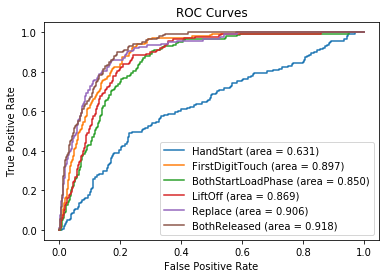

53062 53062
Train subject 12, class HandStart
Train on 1956 samples, validate on 489 samples
Epoch 1/100
1956/1956 [==============================] - 2s 1ms/step - loss: 0.6936 - acc: 0.5015 - val_loss: 0.6941 - val_acc: 0.4581
Epoch 2/100
1956/1956 [==============================] - 1s 366us/step - loss: 0.6948 - acc: 0.4872 - val_loss: 0.6938 - val_acc: 0.4703
Epoch 3/100
1956/1956 [==============================] - 1s 355us/step - loss: 0.6935 - acc: 0.4985 - val_loss: 0.6935 - val_acc: 0.4908
Epoch 4/100
1956/1956 [==============================] - 1s 372us/step - loss: 0.6958 - acc: 0.4806 - val_loss: 0.6934 - val_acc: 0.4969
Epoch 5/100
1956/1956 [==============================] - 1s 372us/step - loss: 0.6952 - acc: 0.4959 - val_loss: 0.6932 - val_acc: 0.5092
Epoch 6/100
1956/1956 [==============================] - 1s 359us/step - loss: 0.6933 - acc: 0.5015 - val_loss: 0.6931 - val_acc: 0.5133
Epoch 7/100
1956/1956 [==============================] - 1s 362us/step - loss: 0.6937 -

Epoch 60/100
1956/1956 [==============================] - 1s 361us/step - loss: 0.6892 - acc: 0.5475 - val_loss: 0.6881 - val_acc: 0.5869
Epoch 61/100
1956/1956 [==============================] - 1s 365us/step - loss: 0.6893 - acc: 0.5547 - val_loss: 0.6880 - val_acc: 0.5890
Epoch 62/100
1956/1956 [==============================] - 1s 368us/step - loss: 0.6881 - acc: 0.5496 - val_loss: 0.6879 - val_acc: 0.5910
Epoch 63/100
1956/1956 [==============================] - 1s 363us/step - loss: 0.6892 - acc: 0.5378 - val_loss: 0.6877 - val_acc: 0.5951
Epoch 64/100
1956/1956 [==============================] - 1s 365us/step - loss: 0.6914 - acc: 0.5348 - val_loss: 0.6874 - val_acc: 0.5890
Epoch 65/100
1956/1956 [==============================] - 1s 360us/step - loss: 0.6893 - acc: 0.5532 - val_loss: 0.6874 - val_acc: 0.6012
Epoch 66/100
1956/1956 [==============================] - 1s 365us/step - loss: 0.6872 - acc: 0.5644 - val_loss: 0.6873 - val_acc: 0.6012
Epoch 67/100
1956/1956 [==========

1956/1956 [==============================] - 1s 370us/step - loss: 0.6807 - acc: 0.5767 - val_loss: 0.6755 - val_acc: 0.6115
Epoch 20/100
1956/1956 [==============================] - 1s 364us/step - loss: 0.6787 - acc: 0.5920 - val_loss: 0.6755 - val_acc: 0.6053
Epoch 21/100
1956/1956 [==============================] - 1s 360us/step - loss: 0.6760 - acc: 0.5966 - val_loss: 0.6748 - val_acc: 0.6115
Epoch 22/100
1956/1956 [==============================] - 1s 357us/step - loss: 0.6782 - acc: 0.5951 - val_loss: 0.6747 - val_acc: 0.6012
Epoch 23/100
1956/1956 [==============================] - 1s 354us/step - loss: 0.6769 - acc: 0.6053 - val_loss: 0.6743 - val_acc: 0.6053
Epoch 24/100
1956/1956 [==============================] - 1s 362us/step - loss: 0.6753 - acc: 0.5920 - val_loss: 0.6739 - val_acc: 0.6053
Epoch 25/100
1956/1956 [==============================] - 1s 363us/step - loss: 0.6755 - acc: 0.5971 - val_loss: 0.6733 - val_acc: 0.6012
Epoch 26/100
1956/1956 [=======================

1956/1956 [==============================] - 1s 366us/step - loss: 0.6360 - acc: 0.6452 - val_loss: 0.6361 - val_acc: 0.6462
Epoch 79/100
1956/1956 [==============================] - 1s 363us/step - loss: 0.6321 - acc: 0.6493 - val_loss: 0.6353 - val_acc: 0.6339
Epoch 80/100
1956/1956 [==============================] - 1s 360us/step - loss: 0.6340 - acc: 0.6498 - val_loss: 0.6345 - val_acc: 0.6421
Epoch 81/100
1956/1956 [==============================] - 1s 357us/step - loss: 0.6301 - acc: 0.6621 - val_loss: 0.6342 - val_acc: 0.6544
Epoch 82/100
1956/1956 [==============================] - 1s 360us/step - loss: 0.6274 - acc: 0.6636 - val_loss: 0.6331 - val_acc: 0.6503
Epoch 83/100
1956/1956 [==============================] - 1s 360us/step - loss: 0.6327 - acc: 0.6503 - val_loss: 0.6323 - val_acc: 0.6483
Epoch 84/100
1956/1956 [==============================] - 1s 362us/step - loss: 0.6303 - acc: 0.6493 - val_loss: 0.6319 - val_acc: 0.6503
Epoch 85/100
1956/1956 [=======================

1956/1956 [==============================] - 1s 379us/step - loss: 0.6806 - acc: 0.5813 - val_loss: 0.6752 - val_acc: 0.6503
Epoch 37/100
1956/1956 [==============================] - 1s 381us/step - loss: 0.6797 - acc: 0.5828 - val_loss: 0.6741 - val_acc: 0.6564
Epoch 38/100
1956/1956 [==============================] - 1s 362us/step - loss: 0.6816 - acc: 0.5649 - val_loss: 0.6732 - val_acc: 0.6544
Epoch 39/100
1956/1956 [==============================] - 1s 378us/step - loss: 0.6776 - acc: 0.6109 - val_loss: 0.6725 - val_acc: 0.6524
Epoch 40/100
1956/1956 [==============================] - 1s 391us/step - loss: 0.6782 - acc: 0.5859 - val_loss: 0.6719 - val_acc: 0.6564
Epoch 41/100
1956/1956 [==============================] - 1s 364us/step - loss: 0.6746 - acc: 0.6155 - val_loss: 0.6710 - val_acc: 0.6605
Epoch 42/100
1956/1956 [==============================] - 1s 368us/step - loss: 0.6789 - acc: 0.5828 - val_loss: 0.6700 - val_acc: 0.6483
Epoch 43/100
1956/1956 [=======================

1956/1956 [==============================] - 1s 369us/step - loss: 0.5829 - acc: 0.7137 - val_loss: 0.5545 - val_acc: 0.7444
Epoch 96/100
1956/1956 [==============================] - 1s 355us/step - loss: 0.5778 - acc: 0.7137 - val_loss: 0.5525 - val_acc: 0.7403
Epoch 97/100
1956/1956 [==============================] - 1s 354us/step - loss: 0.5706 - acc: 0.7101 - val_loss: 0.5493 - val_acc: 0.7382
Epoch 98/100
1956/1956 [==============================] - 1s 352us/step - loss: 0.5743 - acc: 0.7127 - val_loss: 0.5459 - val_acc: 0.7526
Epoch 99/100
1956/1956 [==============================] - 1s 372us/step - loss: 0.5707 - acc: 0.7178 - val_loss: 0.5441 - val_acc: 0.7423
Epoch 100/100
1956/1956 [==============================] - 1s 360us/step - loss: 0.5719 - acc: 0.7122 - val_loss: 0.5435 - val_acc: 0.7485
Train on 1956 samples, validate on 489 samples
Epoch 1/100
1956/1956 [==============================] - 1s 355us/step - loss: 0.5709 - acc: 0.7117 - val_loss: 0.5467 - val_acc: 0.7362


1956/1956 [==============================] - 1s 364us/step - loss: 0.4623 - acc: 0.7802 - val_loss: 0.4458 - val_acc: 0.7873
Epoch 55/100
1956/1956 [==============================] - 1s 348us/step - loss: 0.4602 - acc: 0.7878 - val_loss: 0.4417 - val_acc: 0.7894
Epoch 56/100
1956/1956 [==============================] - 1s 350us/step - loss: 0.4552 - acc: 0.7832 - val_loss: 0.4414 - val_acc: 0.7873
Epoch 57/100
1956/1956 [==============================] - 1s 352us/step - loss: 0.4526 - acc: 0.7965 - val_loss: 0.4396 - val_acc: 0.7853
Epoch 58/100
1956/1956 [==============================] - 1s 353us/step - loss: 0.4559 - acc: 0.7822 - val_loss: 0.4430 - val_acc: 0.7894
Epoch 59/100
1956/1956 [==============================] - 1s 347us/step - loss: 0.4592 - acc: 0.7924 - val_loss: 0.4346 - val_acc: 0.7873
Epoch 60/100
1956/1956 [==============================] - 1s 354us/step - loss: 0.4543 - acc: 0.7940 - val_loss: 0.4347 - val_acc: 0.7955
Epoch 61/100
1956/1956 [=======================

1956/1956 [==============================] - 1s 375us/step - loss: 0.6923 - acc: 0.5322 - val_loss: 0.6897 - val_acc: 0.5665
Epoch 13/100
1956/1956 [==============================] - 1s 375us/step - loss: 0.6902 - acc: 0.5486 - val_loss: 0.6894 - val_acc: 0.5746
Epoch 14/100
1956/1956 [==============================] - 1s 409us/step - loss: 0.6892 - acc: 0.5445 - val_loss: 0.6892 - val_acc: 0.5746
Epoch 15/100
1956/1956 [==============================] - 1s 385us/step - loss: 0.6912 - acc: 0.5102 - val_loss: 0.6889 - val_acc: 0.5787
Epoch 16/100
1956/1956 [==============================] - 1s 370us/step - loss: 0.6920 - acc: 0.5169 - val_loss: 0.6887 - val_acc: 0.5828
Epoch 17/100
1956/1956 [==============================] - 1s 369us/step - loss: 0.6912 - acc: 0.5251 - val_loss: 0.6884 - val_acc: 0.5849
Epoch 18/100
1956/1956 [==============================] - 1s 410us/step - loss: 0.6898 - acc: 0.5455 - val_loss: 0.6881 - val_acc: 0.5849
Epoch 19/100
1956/1956 [=======================

1956/1956 [==============================] - 1s 382us/step - loss: 0.6586 - acc: 0.6437 - val_loss: 0.6501 - val_acc: 0.6442
Epoch 72/100
1956/1956 [==============================] - 1s 395us/step - loss: 0.6578 - acc: 0.6483 - val_loss: 0.6483 - val_acc: 0.6442
Epoch 73/100
1956/1956 [==============================] - 1s 354us/step - loss: 0.6531 - acc: 0.6467 - val_loss: 0.6464 - val_acc: 0.6524
Epoch 74/100
1956/1956 [==============================] - 1s 411us/step - loss: 0.6524 - acc: 0.6544 - val_loss: 0.6442 - val_acc: 0.6605
Epoch 75/100
1956/1956 [==============================] - 1s 367us/step - loss: 0.6516 - acc: 0.6549 - val_loss: 0.6424 - val_acc: 0.6544
Epoch 76/100
1956/1956 [==============================] - 1s 401us/step - loss: 0.6514 - acc: 0.6524 - val_loss: 0.6404 - val_acc: 0.6626
Epoch 77/100
1956/1956 [==============================] - 1s 374us/step - loss: 0.6517 - acc: 0.6396 - val_loss: 0.6383 - val_acc: 0.6605
Epoch 78/100
1956/1956 [=======================

1956/1956 [==============================] - 1s 402us/step - loss: 0.5257 - acc: 0.7439 - val_loss: 0.4913 - val_acc: 0.7607
Epoch 31/100
1956/1956 [==============================] - 1s 394us/step - loss: 0.5303 - acc: 0.7362 - val_loss: 0.4889 - val_acc: 0.7648
Epoch 32/100
1956/1956 [==============================] - 1s 365us/step - loss: 0.5203 - acc: 0.7408 - val_loss: 0.4861 - val_acc: 0.7648
Epoch 33/100
1956/1956 [==============================] - 1s 376us/step - loss: 0.5225 - acc: 0.7382 - val_loss: 0.4869 - val_acc: 0.7751
Epoch 34/100
1956/1956 [==============================] - 1s 382us/step - loss: 0.5198 - acc: 0.7444 - val_loss: 0.4781 - val_acc: 0.7587
Epoch 35/100
1956/1956 [==============================] - 1s 356us/step - loss: 0.5283 - acc: 0.7275 - val_loss: 0.4793 - val_acc: 0.7771
Epoch 36/100
1956/1956 [==============================] - 1s 410us/step - loss: 0.5239 - acc: 0.7336 - val_loss: 0.4763 - val_acc: 0.7751
Epoch 37/100
1956/1956 [=======================

1956/1956 [==============================] - 1s 346us/step - loss: 0.4263 - acc: 0.8006 - val_loss: 0.3882 - val_acc: 0.8200
Epoch 90/100
1956/1956 [==============================] - 1s 373us/step - loss: 0.4161 - acc: 0.8057 - val_loss: 0.3764 - val_acc: 0.8160
Epoch 91/100
1956/1956 [==============================] - 1s 362us/step - loss: 0.4264 - acc: 0.8021 - val_loss: 0.3757 - val_acc: 0.8139
Epoch 92/100
1956/1956 [==============================] - 1s 358us/step - loss: 0.4182 - acc: 0.8170 - val_loss: 0.3747 - val_acc: 0.8160
Epoch 93/100
1956/1956 [==============================] - 1s 355us/step - loss: 0.4181 - acc: 0.8165 - val_loss: 0.3739 - val_acc: 0.8180
Epoch 94/100
1956/1956 [==============================] - 1s 352us/step - loss: 0.4115 - acc: 0.8119 - val_loss: 0.3717 - val_acc: 0.8160
Epoch 95/100
1956/1956 [==============================] - 1s 378us/step - loss: 0.4103 - acc: 0.8067 - val_loss: 0.3681 - val_acc: 0.8139
Epoch 96/100
1956/1956 [=======================

1956/1956 [==============================] - 1s 365us/step - loss: 0.6728 - acc: 0.5920 - val_loss: 0.6744 - val_acc: 0.5767
Epoch 48/100
1956/1956 [==============================] - 1s 364us/step - loss: 0.6705 - acc: 0.5925 - val_loss: 0.6718 - val_acc: 0.5828
Epoch 49/100
1956/1956 [==============================] - 1s 362us/step - loss: 0.6735 - acc: 0.5864 - val_loss: 0.6737 - val_acc: 0.5767
Epoch 50/100
1956/1956 [==============================] - 1s 363us/step - loss: 0.6709 - acc: 0.5951 - val_loss: 0.6713 - val_acc: 0.5828
Epoch 51/100
1956/1956 [==============================] - 1s 365us/step - loss: 0.6704 - acc: 0.5792 - val_loss: 0.6706 - val_acc: 0.5787
Epoch 52/100
1956/1956 [==============================] - 1s 365us/step - loss: 0.6698 - acc: 0.6074 - val_loss: 0.6698 - val_acc: 0.5787
Epoch 53/100
1956/1956 [==============================] - 1s 365us/step - loss: 0.6668 - acc: 0.6007 - val_loss: 0.6684 - val_acc: 0.5787
Epoch 54/100
1956/1956 [=======================

1956/1956 [==============================] - 1s 373us/step - loss: 0.5926 - acc: 0.6948 - val_loss: 0.5530 - val_acc: 0.7464
Epoch 7/100
1956/1956 [==============================] - 1s 360us/step - loss: 0.5810 - acc: 0.7086 - val_loss: 0.5501 - val_acc: 0.7485
Epoch 8/100
1956/1956 [==============================] - 1s 359us/step - loss: 0.5778 - acc: 0.7055 - val_loss: 0.5500 - val_acc: 0.7444
Epoch 9/100
1956/1956 [==============================] - 1s 378us/step - loss: 0.5834 - acc: 0.6958 - val_loss: 0.5470 - val_acc: 0.7444
Epoch 10/100
1956/1956 [==============================] - 1s 369us/step - loss: 0.5733 - acc: 0.7142 - val_loss: 0.5491 - val_acc: 0.7526
Epoch 11/100
1956/1956 [==============================] - 1s 364us/step - loss: 0.5773 - acc: 0.7019 - val_loss: 0.5491 - val_acc: 0.7485
Epoch 12/100
1956/1956 [==============================] - 1s 359us/step - loss: 0.5773 - acc: 0.7147 - val_loss: 0.5447 - val_acc: 0.7464
Epoch 13/100
1956/1956 [==========================

1956/1956 [==============================] - 1s 359us/step - loss: 0.4869 - acc: 0.7771 - val_loss: 0.4932 - val_acc: 0.7710
Epoch 66/100
1956/1956 [==============================] - 1s 369us/step - loss: 0.4904 - acc: 0.7761 - val_loss: 0.4920 - val_acc: 0.7730
Epoch 67/100
1956/1956 [==============================] - 1s 369us/step - loss: 0.4868 - acc: 0.7699 - val_loss: 0.4919 - val_acc: 0.7710
Epoch 68/100
1956/1956 [==============================] - 1s 361us/step - loss: 0.4886 - acc: 0.7797 - val_loss: 0.4881 - val_acc: 0.7689
Epoch 69/100
1956/1956 [==============================] - 1s 364us/step - loss: 0.4922 - acc: 0.7761 - val_loss: 0.4889 - val_acc: 0.7710
Epoch 70/100
1956/1956 [==============================] - 1s 367us/step - loss: 0.4907 - acc: 0.7797 - val_loss: 0.4832 - val_acc: 0.7730
Epoch 71/100
1956/1956 [==============================] - 1s 369us/step - loss: 0.4890 - acc: 0.7704 - val_loss: 0.4872 - val_acc: 0.7751
Epoch 72/100
1956/1956 [=======================

Epoch 24/100
1956/1956 [==============================] - 1s 357us/step - loss: 0.6850 - acc: 0.5741 - val_loss: 0.6813 - val_acc: 0.6830
Epoch 25/100
1956/1956 [==============================] - 1s 354us/step - loss: 0.6849 - acc: 0.5695 - val_loss: 0.6808 - val_acc: 0.6769
Epoch 26/100
1956/1956 [==============================] - 1s 364us/step - loss: 0.6857 - acc: 0.5726 - val_loss: 0.6802 - val_acc: 0.6892
Epoch 27/100
1956/1956 [==============================] - 1s 354us/step - loss: 0.6838 - acc: 0.5706 - val_loss: 0.6796 - val_acc: 0.6912
Epoch 28/100
1956/1956 [==============================] - 1s 365us/step - loss: 0.6834 - acc: 0.5813 - val_loss: 0.6789 - val_acc: 0.6933
Epoch 29/100
1956/1956 [==============================] - 1s 353us/step - loss: 0.6841 - acc: 0.5920 - val_loss: 0.6783 - val_acc: 0.6810
Epoch 30/100
1956/1956 [==============================] - 1s 358us/step - loss: 0.6829 - acc: 0.5869 - val_loss: 0.6776 - val_acc: 0.6953
Epoch 31/100
1956/1956 [==========

1956/1956 [==============================] - 1s 355us/step - loss: 0.5366 - acc: 0.7495 - val_loss: 0.4907 - val_acc: 0.7710
Epoch 84/100
1956/1956 [==============================] - 1s 358us/step - loss: 0.5342 - acc: 0.7531 - val_loss: 0.4821 - val_acc: 0.7751
Epoch 85/100
1956/1956 [==============================] - 1s 356us/step - loss: 0.5269 - acc: 0.7582 - val_loss: 0.4784 - val_acc: 0.7689
Epoch 86/100
1956/1956 [==============================] - 1s 344us/step - loss: 0.5246 - acc: 0.7597 - val_loss: 0.4680 - val_acc: 0.7832
Epoch 87/100
1956/1956 [==============================] - 1s 352us/step - loss: 0.5160 - acc: 0.7669 - val_loss: 0.4611 - val_acc: 0.7894
Epoch 88/100
1956/1956 [==============================] - 1s 354us/step - loss: 0.5071 - acc: 0.7740 - val_loss: 0.4557 - val_acc: 0.7894
Epoch 89/100
1956/1956 [==============================] - 1s 355us/step - loss: 0.5071 - acc: 0.7597 - val_loss: 0.4440 - val_acc: 0.8016
Epoch 90/100
1956/1956 [=======================

1956/1956 [==============================] - 1s 351us/step - loss: 0.3073 - acc: 0.8778 - val_loss: 0.3439 - val_acc: 0.8671
Epoch 43/100
1956/1956 [==============================] - 1s 356us/step - loss: 0.3140 - acc: 0.8712 - val_loss: 0.3359 - val_acc: 0.8671
Epoch 44/100
1956/1956 [==============================] - 1s 357us/step - loss: 0.3072 - acc: 0.8742 - val_loss: 0.3599 - val_acc: 0.8589
Epoch 45/100
1956/1956 [==============================] - 1s 352us/step - loss: 0.3114 - acc: 0.8778 - val_loss: 0.3406 - val_acc: 0.8671
Epoch 46/100
1956/1956 [==============================] - 1s 351us/step - loss: 0.2976 - acc: 0.8850 - val_loss: 0.3368 - val_acc: 0.8671
Epoch 47/100
1956/1956 [==============================] - 1s 352us/step - loss: 0.3092 - acc: 0.8712 - val_loss: 0.3240 - val_acc: 0.8773
Epoch 48/100
1956/1956 [==============================] - 1s 357us/step - loss: 0.3076 - acc: 0.8717 - val_loss: 0.3182 - val_acc: 0.8855
Epoch 49/100
1956/1956 [=======================

Train on 1956 samples, validate on 489 samples
Epoch 1/100
1956/1956 [==============================] - 2s 1ms/step - loss: 0.7056 - acc: 0.4941 - val_loss: 0.6914 - val_acc: 0.5215
Epoch 2/100
1956/1956 [==============================] - 1s 359us/step - loss: 0.7019 - acc: 0.4888 - val_loss: 0.6915 - val_acc: 0.5235
Epoch 3/100
1956/1956 [==============================] - 1s 358us/step - loss: 0.6984 - acc: 0.4990 - val_loss: 0.6920 - val_acc: 0.5194
Epoch 4/100
1956/1956 [==============================] - 1s 361us/step - loss: 0.6984 - acc: 0.4877 - val_loss: 0.6928 - val_acc: 0.5419
Epoch 5/100
1956/1956 [==============================] - 1s 360us/step - loss: 0.6967 - acc: 0.4969 - val_loss: 0.6936 - val_acc: 0.4867
Epoch 6/100
1956/1956 [==============================] - 1s 373us/step - loss: 0.6965 - acc: 0.5020 - val_loss: 0.6943 - val_acc: 0.4826
Epoch 7/100
1956/1956 [==============================] - 1s 361us/step - loss: 0.6962 - acc: 0.4954 - val_loss: 0.6946 - val_acc: 0.4

1956/1956 [==============================] - 1s 358us/step - loss: 0.6860 - acc: 0.5603 - val_loss: 0.6859 - val_acc: 0.5317
Epoch 61/100
1956/1956 [==============================] - 1s 357us/step - loss: 0.6869 - acc: 0.5629 - val_loss: 0.6858 - val_acc: 0.5256
Epoch 62/100
1956/1956 [==============================] - 1s 360us/step - loss: 0.6862 - acc: 0.5470 - val_loss: 0.6848 - val_acc: 0.5501
Epoch 63/100
1956/1956 [==============================] - 1s 363us/step - loss: 0.6876 - acc: 0.5368 - val_loss: 0.6848 - val_acc: 0.5481
Epoch 64/100
1956/1956 [==============================] - 1s 359us/step - loss: 0.6869 - acc: 0.5670 - val_loss: 0.6843 - val_acc: 0.5521
Epoch 65/100
1956/1956 [==============================] - 1s 356us/step - loss: 0.6886 - acc: 0.5527 - val_loss: 0.6839 - val_acc: 0.5542
Epoch 66/100
1956/1956 [==============================] - 1s 359us/step - loss: 0.6875 - acc: 0.5516 - val_loss: 0.6836 - val_acc: 0.5521
Epoch 67/100
1956/1956 [=======================

Epoch 19/100
1956/1956 [==============================] - 1s 362us/step - loss: 0.4812 - acc: 0.7791 - val_loss: 0.4529 - val_acc: 0.8139
Epoch 20/100
1956/1956 [==============================] - 1s 363us/step - loss: 0.4713 - acc: 0.7955 - val_loss: 0.4487 - val_acc: 0.7975
Epoch 21/100
1956/1956 [==============================] - 1s 360us/step - loss: 0.4576 - acc: 0.7950 - val_loss: 0.4354 - val_acc: 0.8200
Epoch 22/100
1956/1956 [==============================] - 1s 361us/step - loss: 0.4615 - acc: 0.7919 - val_loss: 0.4337 - val_acc: 0.8037
Epoch 23/100
1956/1956 [==============================] - 1s 359us/step - loss: 0.4560 - acc: 0.7909 - val_loss: 0.4219 - val_acc: 0.8200
Epoch 24/100
1956/1956 [==============================] - 1s 358us/step - loss: 0.4317 - acc: 0.8062 - val_loss: 0.4164 - val_acc: 0.8241
Epoch 25/100
1956/1956 [==============================] - 1s 358us/step - loss: 0.4330 - acc: 0.8078 - val_loss: 0.4082 - val_acc: 0.8303
Epoch 26/100
1956/1956 [==========

1956/1956 [==============================] - 1s 418us/step - loss: 0.3345 - acc: 0.8625 - val_loss: 0.3132 - val_acc: 0.8937
Epoch 79/100
1956/1956 [==============================] - 1s 360us/step - loss: 0.3400 - acc: 0.8666 - val_loss: 0.3124 - val_acc: 0.8937
Epoch 80/100
1956/1956 [==============================] - 1s 390us/step - loss: 0.3424 - acc: 0.8701 - val_loss: 0.3123 - val_acc: 0.8916
Epoch 81/100
1956/1956 [==============================] - 1s 369us/step - loss: 0.3336 - acc: 0.8650 - val_loss: 0.3113 - val_acc: 0.8937
Epoch 82/100
1956/1956 [==============================] - 1s 404us/step - loss: 0.3261 - acc: 0.8691 - val_loss: 0.3102 - val_acc: 0.8937
Epoch 83/100
1956/1956 [==============================] - 1s 395us/step - loss: 0.3322 - acc: 0.8650 - val_loss: 0.3094 - val_acc: 0.8916
Epoch 84/100
1956/1956 [==============================] - 1s 377us/step - loss: 0.3322 - acc: 0.8645 - val_loss: 0.3088 - val_acc: 0.8978
Epoch 85/100
1956/1956 [=======================

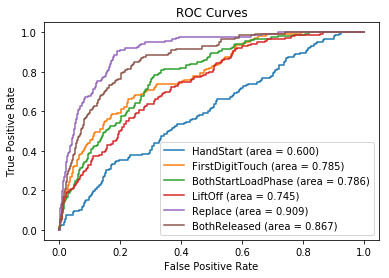

In [17]:


models = []
for i in range(N_LABELS):
    models.append(init_cnn(WINDOW_SIZE))

for subject in TRAIN_SUBJECTS:
    prediction_total = []
    test_data_total = []
    train_data_paths = glob(TRAIN_DATA_PATH % (subject))

    
    x_raw, y_raw = read_training_data(train_data_paths)
    
    x_raw, _ = preprocess_data(x_raw, WINDOW_SIZE, SUBSAMPLE)
#     y_train = y_raw[::SUBSAMPLE]

    x_train, x_test, y_train, y_test = train_test_split(x_raw, y_raw[::SUBSAMPLE], test_size=0.33, shuffle=False)
    x_train, _, y_train, _ = train_test_split(x_train, y_train, test_size=0.0001, shuffle=True)
    print(len(x_test), len(y_test))
    
    for i in range(N_LABELS):
        model = init_cnn(WINDOW_SIZE)
        
        balanced_x_train, balanced_y_train = remove_imbalance(x_train, y_train[:,i])
        

            
        train_labels = to_categorical(balanced_y_train, num_classes = None)
                
        print('Train subject %d, class %s' % (subject, COLUMNS[i]))
        
        x = [balanced_x_train[j::2] for j in range(2)]
        y = [train_labels[j::2] for j in range(2)]
        result = np.array([])
        for sample_x, sample_y in zip(x, y):
            model.fit(np.array(sample_x), np.array(sample_y), verbose=1, validation_split=0.2, epochs=EPOCHS)
        
        
        
#         test_labels = to_categorical(y_test[:,i], num_classes = None)
                
        print('Test subject %d, class %s' % (subject, COLUMNS[i]))                
        predictions = predict_on_sub(x_test, model, SPLIT_SIZE, BATCH_SIZE)
        
        test_data_total.append(y_test[:,i][1000::BATCH_SIZE])
        prediction_total.append(predictions)
        
    multiple_metric_auc_score(prediction_total, test_data_total, True)
        

HandStart AUC score = 0.600
FirstDigitTouch AUC score = 0.785
BothStartLoadPhase AUC score = 0.786
LiftOff AUC score = 0.745
Replace AUC score = 0.909
BothReleased AUC score = 0.867


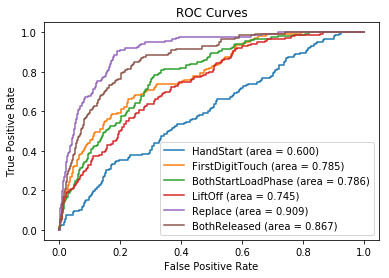

In [18]:
multiple_metric_auc_score(prediction_total, test_data_total, True)